In [1]:
import sys 
sys.path.append(r'./TRPL_dataAnalysis')
import trPL_importClass
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import lil_matrix

Q2_colors = ['#ffc67c', '#f98b2c', "#F16229", '#c71d06', '#942a00', 'black'] 
S_colors = ['#33d1a3', '#04d288', '#098e68', '#046a55', '#054639', 'black']
B2_colors = ['#abc6e5', '#81ADC8', '#62769c', '#465970', '#303d4d', 'black']  

In [3]:
# Encapsulation seems to hold, if done PROPERLY

trPLs = trPL_importClass.trPL_measurement_series(r"./Data/MAPI/Before", BG = 1.6, thickness = 450e-9, denoise = -10, mode = "auto", retime = True)
trPLs.files

['MAPI5', '1200s', '10kHz', 'ND1', '90cps', '0.0504552uW']


['M00-MAPI5_1200s_10kHz_ND1_90cps_0.0504552uW.dat',
 'M01-MAPI5_1200s_10kHz_ND1_420cps_0.195539uW.dat',
 'M02-MAPI5_1200s_10kHz_ND2_600cps_0.5978789999999999uW.dat',
 'M03-MAPI5_1200s_10kHz_ND3_290cps_1.2131399999999999uW.dat']

In [4]:
trPLs.powers

[5.0455199999999995e-08, 1.95539e-07, 5.978789999999999e-07, 1.21314e-06]

In [5]:
N0s = np.array(trPLs.BD_ratio*np.array(trPLs.powers)*trPLs.lambda_laser/(trPLs.spot_area*np.array(trPLs.reprates_Hz)*trPLs.hc)) ## photon/(m2) per pulse
N0s

array([6.47156051e+13, 2.50805164e+14, 7.66860527e+14, 1.55601582e+15])

In [6]:
trPLs_after = trPL_importClass.trPL_measurement_series(r"./Data/MAPI/After", BG = 1.6, thickness = 450e-9, denoise = -100, mode = "auto", retime = True)
trPLs_after.files

['MAPI5', '1200s', '10kHz', 'ND1', '60cps', '0.0504552uW']


['M05-MAPI5_1200s_10kHz_ND1_60cps_0.0504552uW.dat',
 'M06-MAPI5_1200s_10kHz_ND1_160cps_0.195987uW.dat',
 'M07-MAPI5_1200s_10kHz_ND1_1400cps_0.5969840000000001uW.dat',
 'M08-MAPI5_1200s_10kHz_ND2_1090cps_1.2100099999999998uW.dat']

In [7]:
N0s_after = np.array(trPLs_after.BD_ratio*np.array(trPLs_after.powers)*trPLs_after.lambda_laser/(trPLs_after.spot_area*np.array(trPLs_after.reprates_Hz)*trPLs_after.hc)) ## photon/(m2) per pulse
N0s_after 

array([6.47156051e+13, 2.51379784e+14, 7.65712569e+14, 1.55200117e+15])

# Import BOAR

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys, os
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings
# Import boar
#sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *

from scipy.optimize import fsolve
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier


# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings

In [9]:
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '../')) # path to the parent directory
res_dir = os.path.join(parent_dir,'temp') # path to the results directory

In [10]:
from time import perf_counter

In [11]:
class Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion(Agent):
    def __init__(self, default_params = {'N0':1e22, 'kdirect':1e-17, 
                                         'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
                                         'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17,
                                         'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
                                         'ETrap1':1.5, 'ETrap2':1.5, 'ETrap3':1.5,
                                         'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300, 'pw': 70e-12, 'alpha': 1e4*1e5, 'L': 450e-9}) -> None:
        super().__init__()
        self.default_params = default_params
        
    def TRPL_function(self, X, params, Gs = False, take_Log = False, reprates = False, delay = False, constant_floor_normalised_raw = 0, equilibrate = True, N_x = 100, nondimension = True):
        """
        Function to solve ODEs using xdata as time axis. t_off will define a time at which laser is off.
        Parameters
        ----------
        params : 
        xdata [s]: time axis, array like.
        mode: slection of the ODEs to be solved. string: "Decay", "Rise-Decay", "k2".
        t_off [s]: time at which the pulse ends. float.
        N0 [cm-3, cm-3, cm-3]: initial concnetration for decay.
        Returns
        -------
        n, p, ntr at time = t
        """

        pnames = [p.name for p in params if p.val != None]
        
        #Extracting parameters
        if 'N0' in pnames:
            for p in params:
                if p.name == 'N0':
                    N0 = p.val
        else:
            N0 = self.default_params['N0']

        if 'N0_gen' in pnames:
            for p in params:
                if p.name == 'N0_gen':
                    N0_gen = p.val
        else:
            N0_gen = self.default_params['N0_gen']

        if 'kdirect' in pnames:
            for p in params:
                if p.name == 'kdirect':
                    kdirect = p.val
        else:
            kdirect = self.default_params['kdirect']

        bulktrnames = [s for s in pnames if 'Bulk_tr' in s]
        if (bulktrnames):
            Bulk_tr = np.empty((len(bulktrnames),))
            for i, n in enumerate(bulktrnames):  
                for p in params:
                    if p.name == n:
                        Bulk_tr[i] = p.val
        else:
            Bulk_tr = self.default_params['Bulk_tr']

        bnnames = [s for s in pnames if 'Bn' in s]
        if (bnnames):
            Bn = np.empty((len(bnnames),))
            for i, n in enumerate(bnnames):  
                for p in params:
                    if p.name == n:
                        Bn[i] = p.val
        else:
            Bn = self.default_params['Bn']

        bpnames = [s for s in pnames if 'Bp' in s]
        if (bpnames):
            Bp = np.empty((len(bpnames),))
            for i, n in enumerate(bpnames):  
                for p in params:
                    if p.name == n:
                        Bp[i] = p.val
        else:
            Bp = self.default_params['Bp']

        etrapnames = [s for s in pnames if 'ETrap' in s]
        if (etrapnames):
            ETrap = np.empty((len(etrapnames),))
            for i, n in enumerate(etrapnames):  
                for p in params:
                    if p.name == n:
                        ETrap[i] = p.val
        else:
            ETrap = self.default_params['ETrap']

        if 'alpha' in pnames:
            for p in params:
                if p.name == 'alpha':
                    alpha = p.val
        else:
            alpha = self.default_params['alpha']

        if 'pw' in pnames:
            for p in params:
                if p.name == 'pw':
                    pw = p.val
        else:
            pw = self.default_params['pw']

        if 'L' in pnames:
            for p in params:
                if p.name == 'L':
                    L = p.val
        else:
            L = self.default_params['L']

        if 'Eg' in pnames:
            for p in params:
                if p.name == 'Eg':
                    Eg = p.val
        else:
            Eg = self.default_params['Eg']
     
        if 'Nc' in pnames:
            for p in params:
                if p.name == 'Nc':
                    Nc = p.val
        else:
            Nc = self.default_params['Nc']
        if 'Nv' in pnames:
            for p in params:
                if p.name == 'Nv':
                    Nv = p.val
        else:
            Nv = self.default_params['Nv']
        if 'T' in pnames:
            for p in params:
                if p.name == 'T':
                    T = p.val
        else:
            T = self.default_params['T']

        self.L = L  # Length of spatial domain
        self.N_x = N_x
        self.dx = L/(N_x - 1)  # Spatial step size
        self.D = [0.3e-6, 0.3e-6] # From Kzoberni et. al. --> MAPI is around 3x slower
        self.D_d = self.D

        ni = np.sqrt(Nc*Nv*np.exp(-Eg/(constants.value(u'Boltzmann constant in eV/K')*T)))
        p1 = Nv*np.exp(-ETrap/(constants.value(u'Boltzmann constant in eV/K')*T))
        n1 = Nc*np.exp((ETrap-Eg)/(constants.value(u'Boltzmann constant in eV/K')*T))

        #proportion of electrons that are trapped (filling probability at steady state, in the dark)
        ft = (Bn*ni+Bp*p1)/((Bn*(ni+n1))+(Bp*(ni+p1)))
        self.N_traps = len(ft)

        ## ---> Previous expression (seems wrong) Ntrap_init = Bulk_tr*np.exp(-ETrapSingle/(2*constants.value(u'Boltzmann constant in eV/K')*T))
        if ((Gs.any())):
            arg = [kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T]
            #arg = [kdirect, Eg, np.array([0,0]), np.array([0,0]), np.array([0,0]), ETrap, 0, 0, T]
            ids = np.argwhere(X == 0)
            y_total_norm = None
            for i, pos in enumerate(ids):
                #Create the appropriate time vector, for power dependencies.
                if(pos == ids[-1]):
                    time = X[pos[0]:]
                else:
                    time = X[pos[0]:ids[i+1][0]]
            
                if(delay):
                    a = time[time<delay]
                    t = np.concatenate((a, time+delay))
                else:
                    t = time
                # Spatial grid
                x = np.linspace(0, self.L, self.N_x)
                self.x = x
                Ngen = alpha*N0_gen*Gs[i]*np.exp(-alpha*x) #m-2
      
                ## Initial population distribution (uniform for simplicity)
                ## Compute the absorption profile for n (We consider that the n and p diffusion constants are similar... maybe I souldn't), consider constant distribution for the trapped charges at equilibria. 
                ## For now, its constant constant.
                P_init = np.zeros((len(Bulk_tr)+2, self.N_x))
                for j in range(len(P_init)):
                    if (j<2):
                        P_init[j, :] = Ngen
                    else:
                        P_init[j, :] = Bulk_tr[j-2]*ft[j-2]

                # Flatten the initial conditions into a single vector
                P0 = P_init.flatten()
                #Equilibrate the PL decays.
                eq_limit = 1e-2 #1% relative change
                maxcount = 500
                end_point = 1e-20
                RelChange = 1e19
                count = 0
                if (nondimension):
                    Ngen = Ngen/ni
                    P0 = P0/ni
                    self.x = np.linspace(0, 1, N_x)  # nondimensional x
                    self.dx = self.x[1] - self.x[0]  # now dx' = 1 / (N_x - 1)
                    tau = L**2 / self.D[0]
                    t_span = (t[0]/tau, 1/(tau*reprates[i]))
                    arg = [kdirect*ni*tau, Eg, Bulk_tr/ni, Bn*ni*tau, Bp*ni*tau, ETrap, Nc/ni, Nv/ni, T]
                    #arg = [kdirect*ni*tau, Eg, np.array([0,0]), np.array([0,0]), np.array([0,0]), ETrap, 0, 0, T]
                    D_d = [D * tau / L**2 for D in self.D]
                    self.D_d = D_d
    
                if (equilibrate):
                    if(reprates == False):
                        print('no reprates given, while equilibrate is asked')
                        return None
                    #Condition on the max counter but also the time of solving.
                    t_start = perf_counter()
                    t_test = perf_counter()
                    while np.any(abs(RelChange) > eq_limit) and count < maxcount:
                        #coordinates are [pop, x, t]
                        if (t_test - t_start) > 600:
                            #Return noise floor if the solution is extremely slow to find--> probably wrong anyways.
                            print("Sovle time was too long:", t_test - t_start)
                            return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                        
                        self.start_time = perf_counter()
                        if (nondimension):
                            #sol_single = solve_ivp(self.model_vect, [t[0], 1/(reprates[i])], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                            sol_single = solve_ivp(self.model_vect_dimensionless, t_span, P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                        else:
                            sol_single = solve_ivp(self.model_vect, [t[0], 1/(reprates[i])], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                            #sol_single = solve_ivp(self.model, [t[0],1/(reprates[i])], P0, t_eval = t, method='BDF', args=arg, rtol=1e-3, atol=1e-3, min_step = 1e-18, vectorized=vectorised)
                    
                        if not(sol_single.success):
                            print('Integration failed:', sol_single.status, sol_single.message, X.shape)                            
                            if (take_Log):
                                return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                            else:
                                return (constant_floor_normalised_raw[i])*np.ones(len(X))
                        sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)
                        n_last = sol_flat[0, :, -1]
                        p_last = sol_flat[1, :, -1]
                        # Inject fresh carriers
                        n_next = n_last + Ngen
                        p_next = p_last + Ngen
                        # Update initial condition for next iteration
                        P0[:self.N_x] = n_next
                        P0[self.N_x:2*self.N_x] = p_next
                        for j in range(len(Bulk_tr)):
                            u = j+2
                            P0[u*self.N_x:(u+1)*self.N_x] = sol_flat[u,:,-1]

                        new_end = (sol_flat[:,0,-1])
                        RelChange  = ((new_end - end_point)/end_point) # relative change of mean
                        end_point = new_end
                        count += 1
                        t_test = perf_counter()

                    #print("Count is:", count)
                    if (nondimension):
                        #sol_single = solve_ivp(self.model_vect, [t[0],t[-1]], P0, t_eval = t, method='BDF', args=arg, vectorized=vectorised, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3)
                        sol_single = solve_ivp(self.model_vect_dimensionless, [t[0]/tau, t[-1]/tau], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3, t_eval = t/tau)
                    else:
                        sol_single = solve_ivp(self.model_vect, [t[0], t[-1]], P0, method='BDF', args=arg, vectorized=True, jac=self.jacobian_no_flux_vectorized_fixed, rtol=1e-3, atol=1e-3, t_eval=t)
                    
                    sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)
                      
                else:
                    sol_single = solve_ivp(self.model, [t[0],t[-1]], P0, t_eval = t, method='BDF', args=arg, rtol=1e-3, atol=1e-3, min_step = 1e-18, vectorized=True)
                    sol_flat = sol_single.y.reshape(len(P_init), self.N_x, -1)

                if(count > 900):
                    print("Care! Count is: "+str(count))
                if (nondimension):
                    y_single = kdirect*np.trapezoid(ni*ni*sol_flat[0, :, :]*sol_flat[1, :, :], axis = 0, x = self.L*x)
                else:
                    y_single = kdirect*np.trapezoid(sol_flat[0, :, :]*sol_flat[1, :, :], axis = 0, x = x)
                y_single_normalised = y_single/np.amax(y_single) + constant_floor_normalised_raw[i]

                # Somehow sol_single can be different in shape than t, even though its given!
                if not(y_single_normalised.shape == t.shape):
                    print('Shape Problem:', y_single_normalised.shape)
                    fixed = constant_floor_normalised_raw[i]*np.ones(t.shape)
                    if (len(y_single_normalised) < len(t)):
                        fixed[:len(y_single_normalised)] = y_single_normalised
                    else:
                        fixed = y_single_normalised[:len(t)]
                        
                    y_single_normalised = fixed
                   
                if(i == 0):
                    if(take_Log == 'Analysis'):
                        y_total_norm = [sol_flat]
                    else:
                        y_total_norm = y_single_normalised
                else:
                    if(take_Log == 'Analysis'):
                        y_total_norm.append(sol_flat)
                    else:
                        y_total_norm = np.append(y_total_norm, y_single_normalised)

            if (take_Log == True or take_Log == False):
                if (np.isnan(y_total_norm).any() or (y_total_norm < 0).any() or np.isinf(y_total_norm).any()):
                    if (np.isnan(y_total_norm).any()):
                        print("NaN value encountered: Returning Noise Floor")
                    if ((y_total_norm < 0).any()):
                        print("Negative value encountered: Returning Noise Floor")
                    if (np.isinf(y_total_norm).any()):
                        print("Infinite value encountered: Returning Noise Floor")
                        
                    if (take_Log):
                        print((X.shape))
                        return np.log10(1e6*constant_floor_normalised_raw[i])*np.ones(X.shape)
                    else:
                        return (constant_floor_normalised_raw[i]*np.ones(len(X)))
                else:
                    if((y_total_norm < 0).any()):
                        print("Negative value encountered")
                    if(np.isinf(y_total_norm).any()):
                        print("Infinite value encountered")

                    if (take_Log == True):
                        return np.log10(1e6*(y_total_norm))
                    else:
                        return y_total_norm
            else:
                return y_total_norm
        
        else:
            print("This function is for power dependencies. Not single measurements.")
    # Compute the second derivative of the populations
    def second_derivative(self, P, N, dx):
        d2P = np.zeros_like(P)
        d2P[1:-1] = (P[2:] - 2 * P[1:-1] + P[:-2]) / dx**2
        # Zero-flux boundary conditions (d/dx = 0 at boundaries)
        d2P[0] = (P[1] - P[0]) / (dx ** 2)  # Left boundary (forward difference)
        d2P[-1] = (P[-2] - P[-1]) / (dx ** 2)  # Right boundary (backward difference)
        return d2P
    
    def model_vect(self, t, P_flat, kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T):
        if P_flat.ndim == 1:
            P_flat = P_flat[:, None]  # make it (n_variables, 1)

        n_times = P_flat.shape[1]
        
        P = P_flat.reshape(self.N_traps + 2, self.N_x, n_times)  # Now (populations, space, n_times)
        n = P[0]  # shape (space, n_times)
        p = P[1]
        ntr = P[2:]

        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T
        ni2 = Nc*Nv*np.exp(-Eg/kT)
        ni2 = ni2 * np.ones((self.N_x, n_times))

        # Vectorized capture/emission
        e_capture = Bn[:, None, None] * n[None, :, :] * (Bulk_tr[:, None, None] - ntr)
        h_capture = Bp[:, None, None] * p[None, :, :] * ntr
        e_emission = (Nc * np.exp(-(Eg - ETrap) / kT) * Bn)[:, None, None] * ntr
        h_emission = (Nv * np.exp(-ETrap / kT) * Bp)[:, None, None] * (Bulk_tr[:, None, None] - ntr)

        # Diffusion terms
        d2n = np.array([self.second_derivative(n[:, i], self.N_x, self.dx) for i in range(n_times)]).T
        d2p = np.array([self.second_derivative(p[:, i], self.N_x, self.dx) for i in range(n_times)]).T

        dPdt = np.zeros_like(P)

        dPdt[0] = - kdirect * (n * p - ni2) - np.sum(e_capture, axis=0) + np.sum(e_emission, axis=0) + self.D_d[0] * d2n
        dPdt[1] = - kdirect * (n * p - ni2) - np.sum(h_capture, axis=0) + np.sum(h_emission, axis=0) + self.D_d[1] * d2p

        for i in range(self.N_traps):
            dPdt[i+2] = e_capture[i] - e_emission[i] - h_capture[i] + h_emission[i]

        return dPdt.reshape(-1, n_times)
    
    def jacobian_no_flux_vectorized_fixed(self, t, P_flat, *args):

        kdirect, Eg, Bulk_tr, Bn, Bp, ETrap, Nc, Nv, T = args
        
        N_pop = self.N_traps + 2
        nvars = N_pop * self.N_x
        #print("time", t)
        P = P_flat.reshape(N_pop, self.N_x)
        n = P[0]
        p = P[1]
        ntr = P[2:]
      
        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T

        exp_e = Nc * np.exp(-(Eg - ETrap) / kT)
        exp_h = Nv * np.exp(-(ETrap) / kT)

        sum_Bn_Bulktr_ntr = np.sum(Bn[:, None] * (Bulk_tr[:, None] - ntr), axis=0)
        sum_Bp_ntr = np.sum(Bp[:, None] * ntr, axis=0)

        idx_n = np.arange(self.N_x)
        idx_p = self.N_x + np.arange(self.N_x)
        idx_traps = [self.N_x * (2 + j) + np.arange(self.N_x) for j in range(self.N_traps)]

        diag_n = -kdirect * p - sum_Bn_Bulktr_ntr
        diag_p = -kdirect * n - sum_Bp_ntr

        J = lil_matrix((nvars, nvars))

        # Diffusion for n
        diag_n[1:-1] += -2 * self.D_d[0] / self.dx**2
        J[idx_n[1:-1], idx_n[:-2]] = self.D_d[0] / self.dx**2
        J[idx_n[1:-1], idx_n[2:]]  = self.D_d[0] / self.dx**2
        diag_n[0] += -1 * self.D_d[0] / self.dx**2
        J[idx_n[0], idx_n[1]] = self.D_d[0] / self.dx**2
        diag_n[-1] += -1 * self.D_d[0] / self.dx**2
        J[idx_n[-1], idx_n[-2]] = self.D_d[0] / self.dx**2

        # Diffusion for p
        diag_p[1:-1] += -2 * self.D_d[1] / self.dx**2
        J[idx_p[1:-1], idx_p[:-2]] = self.D_d[1] / self.dx**2
        J[idx_p[1:-1], idx_p[2:]]  = self.D_d[1] / self.dx**2
        diag_p[0] += -1 * self.D_d[1] / self.dx**2
        J[idx_p[0], idx_p[1]] = self.D_d[1] / self.dx**2
        diag_p[-1] += -1 * self.D_d[1] / self.dx**2
        J[idx_p[-1], idx_p[-2]] = self.D_d[1] / self.dx**2

        J[idx_n, idx_n] = diag_n
        J[idx_p, idx_p] = diag_p

        J[idx_n, idx_p] = -kdirect * n
        J[idx_p, idx_n] = -kdirect * p

        for j in range(self.N_traps):
            idx_trap = idx_traps[j]
            # Assign trap diagonal block (important!)
            J[idx_trap, idx_trap] = -Bn[j] * n - Bn[j] * exp_e[j] - Bp[j] * p + Bp[j] * exp_h[j]

            # Trap eqns derivatives w.r.t n and p (diagonal only)
            J[idx_trap, idx_n] = Bn[j] * (Bulk_tr[j] - ntr[j])
            J[idx_trap, idx_p] = -Bp[j] * ntr[j]

            # Electron and hole eqns derivatives w.r.t trap populations (diagonal only)
            J[idx_n, idx_trap] = Bn[j] * n + Bn[j] * exp_e[j]
            J[idx_p, idx_trap] = -Bp[j] * p - Bp[j] * exp_h[j]

        return J.tocsc()
    
    def model_vect_dimensionless(self, t, P_flat_d, kdirect, Eg, Bulk_tr_d, Bn, Bp, ETrap, Nc_d, Nv_d, T):
        if P_flat_d.ndim == 1:
            P_flat_d = P_flat_d[:, None]  # make it (n_variables, 1)

        n_times = P_flat_d.shape[1]
        
        P = P_flat_d.reshape(self.N_traps + 2, self.N_x, n_times)  # Now (populations, space, n_times)
        n_d = P[0]  # shape (space, n_times)
        p_d = P[1]
        ntr_d = P[2:]

        kb = constants.value(u'Boltzmann constant in eV/K')
        kT = kb * T
        #ni2 = Nc_d*Nc_d*np.exp(-Eg/kT)
        #ni2 = ni2 * np.ones((self.N_x, n_times))
        #ni = ni*np.ones((self.N_x, n_times))

        # Vectorized capture/emission
        e_capture = Bn[:, None, None] * n_d[None, :, :] * (Bulk_tr_d[:, None, None] - ntr_d)
        h_capture = Bp[:, None, None] * p_d[None, :, :] * ntr_d
        e_emission = (Nc_d * np.exp(-(Eg - ETrap) / kT) * Bn)[:, None, None] * ntr_d
        h_emission = (Nv_d * np.exp(-ETrap / kT) * Bp)[:, None, None] * (Bulk_tr_d[:, None, None] - ntr_d)

        # Diffusion terms
        d2n = np.array([self.second_derivative(n_d[:, i], self.N_x, self.dx) for i in range(n_times)]).T
        d2p = np.array([self.second_derivative(p_d[:, i], self.N_x, self.dx) for i in range(n_times)]).T

        dPdt = np.zeros_like(P)

        dPdt[0] = - kdirect * (n_d * p_d - 1) - np.sum(e_capture, axis=0) + np.sum(e_emission, axis=0) + self.D_d[0] * d2n
        dPdt[1] = - kdirect * (n_d * p_d - 1) - np.sum(h_capture, axis=0) + np.sum(h_emission, axis=0) + self.D_d[1] * d2p

        for i in range(self.N_traps):
            dPdt[i+2] = (e_capture[i] - e_emission[i] - h_capture[i] + h_emission[i])

        return dPdt.reshape(-1, n_times)

# Fitting

In [12]:
import scipy
def fitfunc(x, *args):
        """
        
        Used for fitting of a multi (varying amount defined by len(args)) of exponential decay.

        Parameters
        ----------
        x: evaluation points of function.
        
        *args : arguments for multiexponential decay. len(args) has to be 2n + 1.
            
        Returns
        -------
        f = arg[0] + arg[1]*exp(-arg[2]*x) + ... + arg[i]*exp(-arg[i+1]*x)
        
        """
        #print(args)
        params = np.array([arg for arg in args])
        
        if ((len(params) == 1) or (len(params) > 20)):
            print("Number of params is wrong n = "+str(len(params))+"\n")
        
        s = params[0]
        for i, a in enumerate(params):
            if (i == 0):
                continue
            if not(i % 2):
                continue
            else:
                s = s + params[i]*np.exp(-params[i+1]*x)
                
        return (s)

r = 1.0
r = 1.0
r = 1.0
[ 1.          3.87549747 11.84970033 24.0439043 ]


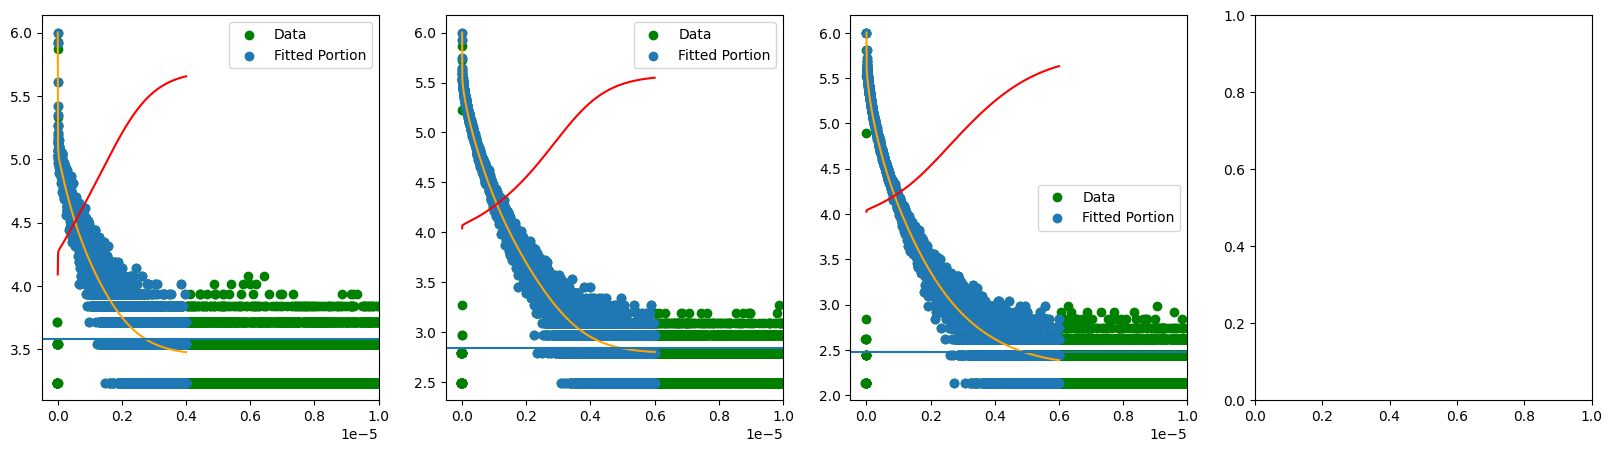

In [13]:
#fit1

fig, ax = plt.subplots(1,4, figsize = (20,5))
delay1 = 0 #delay in ns
id_start = np.argmax(trPLs.TRPLs_raw[:,0])+delay1
fit_stops = [4e-6, 6e-6, 6e-6, 6e-6]
selection_before = [0, 1, 2]


ratios1 = np.array(trPLs.powers)/trPLs.powers[0]
noises1 = []

for i, sPL in enumerate(selection_before):
    #PL = 300e-5
    id_series = sPL

    time_data1 = trPLs.ts[(trPLs.ts[:,id_series] < fit_stops[i]), id_series][id_start:]-trPLs.ts[id_start,id_series]
    trpl_data1 = trPLs.TRPLs_raw[(trPLs.ts[:,id_series] < fit_stops[i]), id_series][id_start:] + 1

    noise1 = np.average(1.2 + 1)
    zeros = trpl_data1 == 1

    r = np.amax(trPLs.TRPLs_raw[:, id_series][id_start:])/np.amax(trPLs.TRPLs_raw[:, id_series][:])
    print("r = "+str(np.sqrt(r)))
    ratios1[i] = ratios1[i]*np.sqrt(r)
    n_exp = 5
    previous_ps, pcov = scipy.optimize.curve_fit(fitfunc, time_data1, trpl_data1, maxfev = 1500000, p0 = [1]*(2*n_exp+1))
    multiexp_fit_data = fitfunc(time_data1, *previous_ps)
    weight = 1/multiexp_fit_data

    noise1 = noise1/np.amax(trpl_data1)
    trpl_data1 = trpl_data1/np.amax(trpl_data1)
    logdata1 = np.log10(1e6*trpl_data1)

    if(i == 0):
        times_data1 = time_data1
        trpls_data1 = trpl_data1
        logdatas1 = logdata1
        weights1 = weight
    
    else:
        times_data1 = np.append(times_data1, time_data1)
        trpls_data1 = np.append(trpls_data1, trpl_data1)
        logdatas1 = np.append(logdatas1, logdata1)
        weights1 = np.append(weights1, weight)

    ax[i].scatter(trPLs.ts[:, id_series]-trPLs.ts[id_start,id_series], np.log10(1e6*(trPLs.TRPLs_raw[:, id_series] + 1)/np.amax(trPLs.TRPLs_raw[id_start:, id_series] +1)), color = "green")
    ax[i].scatter(time_data1, (logdata1))
    ax[i].plot(time_data1, np.log10(1e6*multiexp_fit_data/np.amax(multiexp_fit_data)), color = 'orange')
    ax[i].axhline(np.log10(1e6*noise1))
    ax[i].set_xlim([-0.5e-6, 10e-6])
    
    ax[i].semilogy(time_data1, 4+np.sqrt(5*weight), color = 'red')
    ax[i].legend(['Data', 'Fitted Portion'])
    ax[i].set_yscale('linear')

    noises1.append(noise1)
    
print(ratios1)

r = 1.0
r = 1.0
r = 1.0
[ 1.          3.88437664 11.83196182 23.98186906]


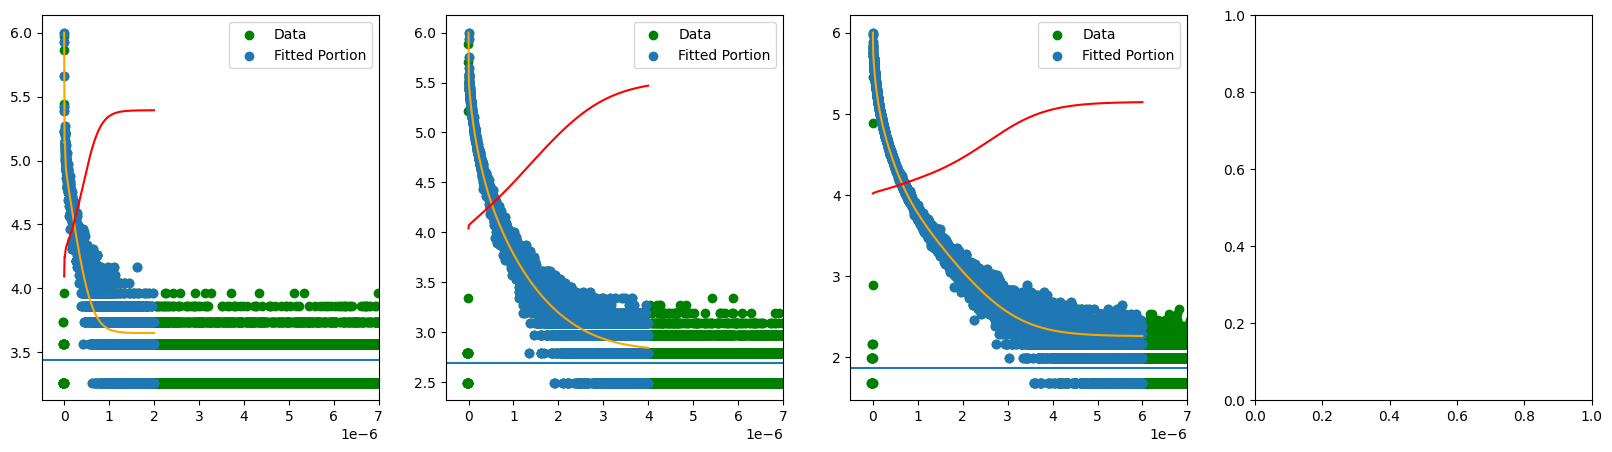

In [14]:
#fit1

fig, ax = plt.subplots(1,4, figsize = (20,5))
delay2 = 0 #delay in ns
id_start = np.argmax(trPLs_after.TRPLs_raw[:,0])+delay2
fit_stops = [2e-6, 4e-6, 6e-6, 6e-6]
selection_after = [0, 1, 2]

ratios2 = np.array(trPLs_after.powers)/trPLs_after.powers[0]
noises2 = []

for i, sPL in enumerate(selection_after):
    #PL = 300e-5
    id_series = sPL

    time_data2 = trPLs_after.ts[(trPLs_after.ts[:,id_series] < fit_stops[i]), id_series][id_start:]-trPLs_after.ts[id_start,id_series]
    trpl_data2 = trPLs_after.TRPLs_raw[(trPLs_after.ts[:,id_series] < fit_stops[i]), id_series][id_start:] + 1

    noise2 = np.average(trPLs_after.TRPLs_raw[-100:, id_series] + 1)
    zeros = trpl_data2 == 1

    r = np.amax(trPLs_after.TRPLs_raw[:, id_series][id_start:])/np.amax(trPLs_after.TRPLs_raw[:, id_series][:])
    print("r = "+str(np.sqrt(r)))
    ratios2[i] = ratios2[i]*np.sqrt(r)
    n_exp = 5
    previous_ps, pcov = scipy.optimize.curve_fit(fitfunc, time_data2, trpl_data2, maxfev = 1500000, p0 = [1]*(2*n_exp+1))
    multiexp_fit_data = fitfunc(time_data2, *previous_ps)
    weight = 1/multiexp_fit_data

    noise2 = noise2/np.amax(trpl_data2)
    trpl_data2 = trpl_data2/np.amax(trpl_data2)
    logdata2 = np.log10(1e6*trpl_data2)

    if(i == 0):
        times_data2 = time_data2
        trpls_data2 = trpl_data2
        logdatas2 = logdata2
        weights2 = weight
    
    else:
        times_data2 = np.append(times_data2, time_data2)
        trpls_data2 = np.append(trpls_data2, trpl_data2)
        logdatas2 = np.append(logdatas2, logdata2)
        weights2 = np.append(weights2, weight)

    ax[i].scatter(trPLs_after.ts[:, id_series]-trPLs_after.ts[id_start,id_series], np.log10(1e6*(trPLs_after.TRPLs_raw[:, id_series] + 1)/np.amax(trPLs_after.TRPLs_raw[id_start:, id_series] +1)), color = "green")
    ax[i].scatter(time_data2, (logdata2))
    ax[i].plot(time_data2, np.log10(1e6*multiexp_fit_data/np.amax(multiexp_fit_data)), color = 'orange')
    ax[i].axhline(np.log10(1e6*noise2))
    ax[i].set_xlim([-0.5e-6, 7e-6])
    
    ax[i].semilogy(time_data2, 4+np.sqrt(5*weight), color = 'red')
    ax[i].legend(['Data', 'Fitted Portion'])
    ax[i].set_yscale('linear')

    noises2.append(noise2)
    

#ratios2 = ratios2/ratios2[0]
print(ratios2)

In [15]:
params = []
a_MAPI = 31334.55409947516 #From measurements with Manuel
true_values = {'N0':1e21, 'kdirect':1e-17, 
            'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
            'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17, 
            'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
            'ETrap1':1.5, 'ETrap2':1.45, 'ETrap3':1.40, 
            'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300 }

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params.append(Bulk_tr2)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-16, 1e-6], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params.append(Bn2)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params.append(Bp2)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.5, trPLs.BG-0.2], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs.BG-0.4, trPLs.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params.append(ETrap2)

N0_gen = Fitparam(name='N0_gen', val=N0s[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a_MAPI, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params.append(N0)

BG = Fitparam(name='Eg', val=trPLs.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params.append(Nv)

params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1e+24, relRange=1, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1e+24, relRange=1, lims=[1e+18, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1e-17, relRange=1, lims=[1e-20, 1e-10], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn2, val=1e-17, relRange=1, lims=[1e-16, 1e-06], std=0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bp1, val=1e-17, relRange=1, lims=[1e-20, 1e-10], std=0, 

In [33]:
params_after2 = []
a_MAPI = 31334.55409947516 #From measurements with Manuel
true_values = {'N0':1e21, 'kdirect':1e-17, 
            'Bulk_tr1':1e24, 'Bulk_tr2':1e24, 'Bulk_tr3':1e24,
            'Bn1':1e-17, 'Bn2':1e-17, 'Bn3':1e-17, 
            'Bp1':1e-17, 'Bp2':1e-17, 'Bp3':1e-17, 
            'ETrap1':1.5, 'ETrap2':1.45, 'ETrap3':1.40, 
            'Eg':1.6, 'G': 1e29, 'Gfrac':1, 'Nc':2e24, 'Nv': 2e24, 'T': 300 }

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_after2.append(kdirect)

kdirect = Fitparam(name = 'kdirect', val =  1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_after2.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val = true_values['Bulk_tr1'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after2.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after2.append(Bulk_tr2)
Bulk_tr3 = Fitparam(name = 'Bulk_tr3', val = true_values['Bulk_tr3'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_after2.append(Bulk_tr3)
#Deep
Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-8], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bn1)
#Shallow 1
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-16, 1e-7], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bn2)
#Shallow 2
Bn3 = Fitparam(name = 'Bn3', val = true_values['Bn3'], lims = [1e-16, 1e-7], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bn3)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-25, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bp1)
#Shallow
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bp2)
Bp3 = Fitparam(name = 'Bp3', val = true_values['Bp3'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_after2.append(Bp3)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.3, 1.599], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params_after2.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [1.4, 1.599], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params_after2.append(ETrap2)
ETrap3 = Fitparam(name = 'ETrap3', val = true_values['ETrap3'], lims = [1.4, 1.599], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single3}$', unit='eV')
params_after2.append(ETrap3)

N0_gen = Fitparam(name='N0_gen', val=N0s_after[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after2.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a_MAPI, relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after2.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after2.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_after2.append(N0)

BG = Fitparam(name='Eg', val=trPLs_after.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params_after2.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs_after.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params_after2.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs_after.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params_after2.append(Nv)

params_after2

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1e+24, relRange=1, lims=[1e+19, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1e+24, relRange=1, lims=[1e+19, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1e+24, relRange=1, lims=[1e+19, 1e+25], std=0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1e-17, relRange=1, lims=[1e-20, 1e-08], std

In [17]:
trPLs_after.BG

1.6

In [57]:
params_before = []
a_MAPI = 31334.55409947516 #From measurements with Manuel

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_before.append(kdirect)

# Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val = true_values['Bulk_tr1'], lims = [1e19, 1e26], relRange = 1, range_type = 'log',
#             lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
# params_before.append(Bulk_tr1)
# Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e19, 1e26], relRange = 1, range_type = 'log',
#             lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
# params_before.append(Bulk_tr2)
# Bulk_tr3 = Fitparam(name = 'Bulk_tr3', val = 1, lims = [1e19, 1e26], relRange = 1, range_type = 'log',
#             lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
# params_before.append(Bulk_tr3)

# Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-17, 1e-13], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bn1)
# Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-18, 1e-14], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bn2)
# Bn3 = Fitparam(name = 'Bn3', val =true_values['Bn3'], lims = [1e-16, 1e-12], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bn3)

# Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-19, 1e-15], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bp1)
# Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-29, 1e-24], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bp2)
# Bp3 = Fitparam(name = 'Bp3', val = true_values['Bp2'], lims = [1e-21, 1e-16], relRange = 1, range_type = 'log', 
#             lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
# params_before.append(Bp3)

# ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [1.2, 1.599], relRange = 1, range_type = 'linear', 
#             lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
# params_before.append(ETrap1)
# ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [1.4, 1.599], relRange = 1, range_type = 'linear', 
#                   lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
# params_before.append(ETrap2)
# ETrap3 = Fitparam(name = 'ETrap3', val = true_values['ETrap3'], lims = [0.5, 1.3], relRange = 1, range_type = 'linear', 
#                   lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single3}$', unit='eV')
# params_before.append(ETrap3)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr2)
Bulk_tr3 = Fitparam(name = 'Bulk_tr3', val =  true_values['Bulk_tr3'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr3)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-15, 1e-5], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn2)
Bn3 = Fitparam(name = 'Bn3', val = 1e-12, lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn3)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp2)
Bp3 = Fitparam(name = 'Bp3', val = 1e-20, lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp3)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.7, trPLs_after.BG-0.2], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params_before.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs_after.BG-0.4, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params_before.append(ETrap2)
ETrap3 = Fitparam(name = 'ETrap3', val = 1.4, lims =[0.7, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single3}$', unit='eV')
params_before.append(ETrap3)

N0_gen = Fitparam(name='N0_gen', val=N0s_after[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a_MAPI, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(N0)

BG = Fitparam(name='Eg', val=trPLs_after.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params_before.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs_after.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params_before.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs_after.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params_before.append(Nv)

In [17]:
params_before2traps = []
a_MAPI = 31334.55409947516 #From measurements with Manuel

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_before2traps.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before2traps.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e18, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before2traps.append(Bulk_tr2)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before2traps.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-16, 1e-6], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before2traps.append(Bn2)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before2traps.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-30, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before2traps.append(Bp2)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.2, trPLs.BG-0.2], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params_before2traps.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs.BG-0.4, trPLs.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params_before2traps.append(ETrap2)

N0_gen = Fitparam(name='N0_gen', val=N0s_after[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before2traps.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a_MAPI, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before2traps.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before2traps.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before2traps.append(N0)

BG = Fitparam(name='Eg', val=trPLs_after.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params_before2traps.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs_after.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params_before2traps.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs_after.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params_before2traps.append(Nv)

MSE = 0.5858751930971202


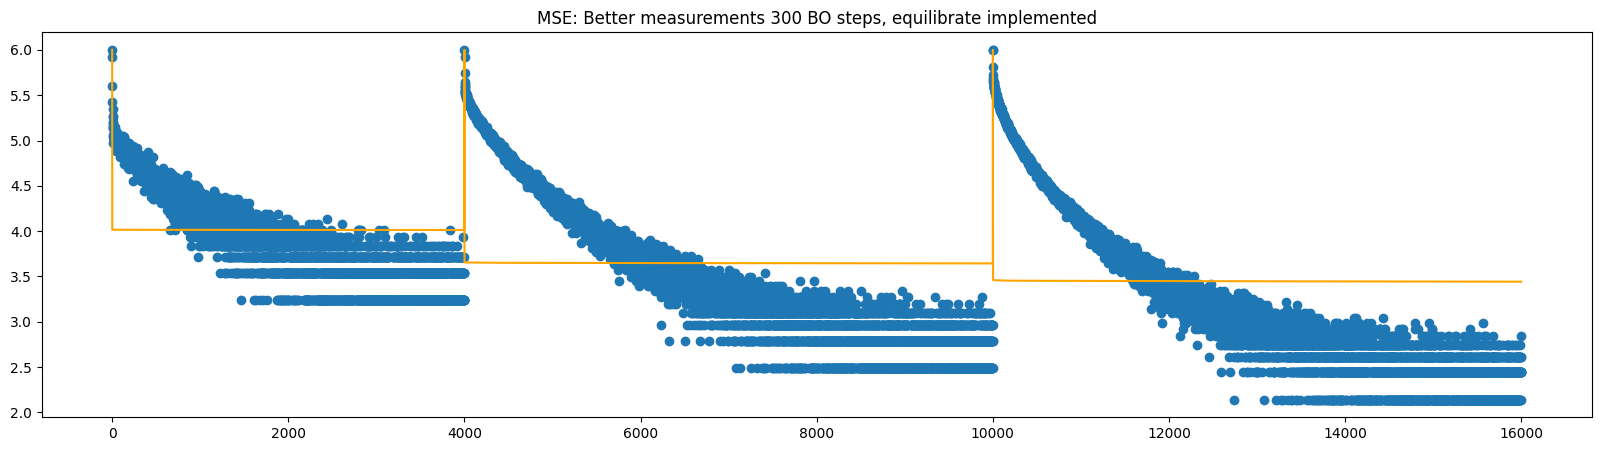

In [19]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, params_before, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, vectorised = True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

In [87]:
#Fit 1: Before
if 'mo_before' in locals():
    del mo_before

for i in range(1):
    print("-------------------------------------------------------------------Starting Fit: "+str(i)+"--------------------------------------------------------")
    X_dimension = ['t']
    y_dimension = 'PL [a.u.]'

    trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

    if 'target' in locals():
        del target

    if 'mo_new' in locals():
        del mo_new

    target = {'model':partial(trPL_agent.TRPL_function, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True), 'target_name':'trPL', 
              'data':{'X':times_data1, 'y':logdatas1, 'X_dimensions':X_dimension, 'X_units':'s', 'y_dimension':y_dimension, 'y_unit':''}, 'weight': 1, 'target_weight':1}

    mo_new = MooBOtorch(targets = [target], params = params_after2, res_dir=res_dir, parallel=False, verbose=True)
    obj_type="MSE" #MLE_trPL_MS"#'MSE'#'hausdorff'
    loss= 'linear' #'soft_l1' #It takes the sqrt(MSE)
    threshold=0.5#50

    kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':true_values,'show_points':True,'savefig':False,'full_grid':True,'randomize':True}

    ax_client = mo_new.BoTorchOpti(n_jobs = [4,4], n_step_points = [150, 300], models = ['Sobol','GPEI'], obj_type = obj_type, loss = loss, threshold = threshold,use_CUDA=False,is_MOO = False, verbose = True, show_posterior = False, kwargs_posterior = kwargs_posterior)
    
    import pickle
    with open('./250526-results_BOs-MAPIBefore-N0Fixed-kradFixed-OneDeepTwoShalowTrap-powersratios-150300times-'+str(0)+'.pickle', 'wb') as handle:
        pickle.dump(mo_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

[INFO 05-26 08:48:27] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-26 08:48:27] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Bulk_tr1', parameter_type=FLOAT, range=[19.0, 25.0]), RangeParameter(name='Bulk_tr2', parameter_type=FLOAT, range=[19.0, 25.0]), RangeParameter(name='Bulk_tr3', parameter_type=FLOAT, range=[19.0, 25.0]), RangeParameter(name='Bn1', parameter_type=FLOAT, range=[-20.0, -8.0]), RangeParameter(name='Bn2', parameter_type=FLOAT, range=[-16.0, -7.0]), RangeParameter(name='Bn3', parameter_type=FLOAT, range=[-16.0, -7.0]), RangeParameter(name='Bp1', parameter_type=FLOAT, range=[-25.0, -10.0]), RangeParameter(name='Bp2', parameter_type=FLOAT, range=[-30.0, -15.0]), RangeParameter(name='Bp3', parameter_type=FLOAT, range=[-30.0, -15.0]), RangeParameter(name='ET

-------------------------------------------------------------------Starting Fit: 0--------------------------------------------------------


[INFO 05-26 08:48:27] ax.service.ax_client: Generated new trial 0 with parameters {'Bulk_tr1': 23.041249, 'Bulk_tr2': 24.107654, 'Bulk_tr3': 24.395338, 'Bn1': -14.354897, 'Bn2': -14.472361, 'Bn3': -14.330951, 'Bp1': -22.581549, 'Bp2': -20.519788, 'Bp3': -28.804547, 'ETrap1': 1.595546, 'ETrap2': 1.455604, 'ETrap3': 1.578021} using model Sobol.
[INFO 05-26 08:48:27] ax.service.ax_client: Generated new trial 1 with parameters {'Bulk_tr1': 20.676877, 'Bulk_tr2': 19.30507, 'Bulk_tr3': 20.690818, 'Bn1': -12.828649, 'Bn2': -9.966137, 'Bn3': -7.514725, 'Bp1': -15.060425, 'Bp2': -25.444778, 'Bp3': -20.691914, 'ETrap1': 0.375958, 'ETrap2': 1.507772, 'ETrap3': 1.478334} using model Sobol.
[INFO 05-26 08:48:27] ax.service.ax_client: Generated new trial 2 with parameters {'Bulk_tr1': 20.154062, 'Bulk_tr2': 22.562255, 'Bulk_tr3': 23.0846, 'Bn1': -19.975689, 'Bn2': -9.177614, 'Bn3': -11.089068, 'Bp1': -20.829034, 'Bp2': -27.23204, 'Bp3': -15.967079, 'ETrap1': 0.665127, 'ETrap2': 1.554275, 'ETrap3': 1

Sovle time was too long: 621.8760698999977


[INFO 05-26 09:08:11] ax.service.ax_client: Generated new trial 96 with parameters {'Bulk_tr1': 22.775329, 'Bulk_tr2': 24.426417, 'Bulk_tr3': 22.723694, 'Bn1': -18.969972, 'Bn2': -10.085185, 'Bn3': -7.637545, 'Bp1': -18.642409, 'Bp2': -24.976096, 'Bp3': -23.95733, 'ETrap1': 1.481161, 'ETrap2': 1.519454, 'ETrap3': 1.419501} using model Sobol.
[INFO 05-26 09:08:11] ax.service.ax_client: Generated new trial 97 with parameters {'Bulk_tr1': 20.756569, 'Bulk_tr2': 20.205558, 'Bulk_tr3': 20.147699, 'Bn1': -8.496263, 'Bn2': -14.561265, 'Bn3': -14.171903, 'Bp1': -11.14888, 'Bp2': -19.11427, 'Bp3': -16.077471, 'ETrap1': 0.429057, 'ETrap2': 1.465712, 'ETrap3': 1.518789} using model Sobol.
[INFO 05-26 09:08:11] ax.service.ax_client: Generated new trial 98 with parameters {'Bulk_tr1': 20.412557, 'Bulk_tr2': 22.974724, 'Bulk_tr3': 24.029304, 'Bn1': -14.887629, 'Bn2': -13.705688, 'Bn3': -13.430779, 'Bp1': -24.829276, 'Bp2': -17.150791, 'Bp3': -20.846311, 'ETrap1': 0.707884, 'ETrap2': 1.41893, 'ETrap3

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-26 09:18:22] ax.service.ax_client: Generated new trial 170 with parameters {'Bulk_tr1': 21.276224, 'Bulk_tr2': 23.702315, 'Bulk_tr3': 25.0, 'Bn1': -9.671317, 'Bn2': -7.880639, 'Bn3': -7.0, 'Bp1': -17.133624, 'Bp2': -21.113708, 'Bp3': -15.0, 'ETrap1': 0.789773, 'ETrap2': 1.4, 'ETrap3': 1.434327} using model GPEI.
[INFO 05-26 09:18:32] ax.service.ax_client: Generated new trial 171 with parameters {'Bulk_tr1': 21.675865, 'Bulk_tr2': 24.362807, 'Bulk_tr3': 22.530585, 'Bn1': -12.950833, 'Bn2': -7.560051, 'Bn3': -10.15818, 'Bp1': -13.198339, 'Bp2': -30.0, 'Bp3': -17.309292, 'ETrap1': 1.320077, 'ETrap2': 1.445677, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 09:18:47] ax.service.ax_client: Generated new trial 172 with parameters {'Bulk_tr1': 21.406293, 'Bulk_tr2': 24.839338, 'Bulk_tr3': 25.0, 'Bn1': -11.25924, 'Bn2': -10.753579, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -17.188403, 'Bp3': -15.0, 'ETrap1': 0.550985, 'ETrap2': 1.4, 'ETrap3': 1.469328} using model GPEI.
[INFO 05-26 09:18:58] ax

Sovle time was too long: 602.6996066999855


[INFO 05-26 09:37:28] ax.service.ax_client: Completed trial 174 with data: {'MSE': (0.914271, None)}.
[INFO 05-26 09:37:28] ax.service.ax_client: Completed trial 175 with data: {'MSE': (0.554182, None)}.
[INFO 05-26 09:37:28] ax.service.ax_client: Completed trial 176 with data: {'MSE': (1.626538, None)}.
[INFO 05-26 09:37:28] ax.service.ax_client: Completed trial 177 with data: {'MSE': (0.915647, None)}.
[INFO 05-26 09:37:39] ax.service.ax_client: Generated new trial 178 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 22.668235, 'Bulk_tr3': 19.0, 'Bn1': -15.866712, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -17.107072, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.813249, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 09:37:49] ax.service.ax_client: Generated new trial 179 with parameters {'Bulk_tr1': 23.921935, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -18.507184, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -13.253502, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.675921, 'ETrap2': 1.4, 'ETrap3': 1.4

Sovle time was too long: 1165.6426354999421


[INFO 05-26 10:16:16] ax.service.ax_client: Completed trial 190 with data: {'MSE': (0.899758, None)}.
[INFO 05-26 10:16:16] ax.service.ax_client: Completed trial 191 with data: {'MSE': (0.914077, None)}.
[INFO 05-26 10:16:16] ax.service.ax_client: Completed trial 192 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 10:16:16] ax.service.ax_client: Completed trial 193 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 899.4649520999519


[INFO 05-26 10:16:26] ax.service.ax_client: Generated new trial 194 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 22.665346, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -17.968253, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.353605, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 10:16:40] ax.service.ax_client: Generated new trial 195 with parameters {'Bulk_tr1': 21.290349, 'Bulk_tr2': 22.230331, 'Bulk_tr3': 23.163081, 'Bn1': -9.681065, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.417789, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 10:16:52] ax.service.ax_client: Generated new trial 196 with parameters {'Bulk_tr1': 20.637347, 'Bulk_tr2': 19.0, 'Bulk_tr3': 24.156132, 'Bn1': -11.980752, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 10:17:05] ax.service.ax_client: Generated new trial 197 with parameters {'Bulk_

Sovle time was too long: 1068.2363523000386


[INFO 05-26 10:34:59] ax.service.ax_client: Completed trial 194 with data: {'MSE': (0.877222, None)}.
[INFO 05-26 10:34:59] ax.service.ax_client: Completed trial 195 with data: {'MSE': (0.927005, None)}.
[INFO 05-26 10:34:59] ax.service.ax_client: Completed trial 196 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 10:34:59] ax.service.ax_client: Completed trial 197 with data: {'MSE': (0.907933, None)}.
[INFO 05-26 10:35:10] ax.service.ax_client: Generated new trial 198 with parameters {'Bulk_tr1': 20.297222, 'Bulk_tr2': 24.485051, 'Bulk_tr3': 19.0, 'Bn1': -11.01264, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 10:35:21] ax.service.ax_client: Generated new trial 199 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -11.113289, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -11.238248, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model G

Sovle time was too long: 1419.3673281000229
Sovle time was too long: 616.0689891999355


[INFO 05-26 11:19:03] ax.service.ax_client: Completed trial 198 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 11:19:03] ax.service.ax_client: Completed trial 199 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 11:19:03] ax.service.ax_client: Completed trial 200 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 11:19:03] ax.service.ax_client: Completed trial 201 with data: {'MSE': (0.928976, None)}.
[INFO 05-26 11:19:14] ax.service.ax_client: Generated new trial 202 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 22.707313, 'Bulk_tr3': 20.078954, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 11:19:28] ax.service.ax_client: Generated new trial 203 with parameters {'Bulk_tr1': 23.050911, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -17.506384, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.85446, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.801748, 'ETrap2': 1.599, 'ETrap3': 1.4} using mod

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)
Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-26 11:37:52] ax.service.ax_client: Completed trial 214 with data: {'MSE': (1.045656, None)}.
[INFO 05-26 11:37:52] ax.service.ax_client: Completed trial 215 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 11:37:52] ax.service.ax_client: Completed trial 216 with data: {'MSE': (1.227332, None)}.
[INFO 05-26 11:37:52] ax.service.ax_client: Completed trial 217 with data: {'MSE': (0.899668, None)}.
[INFO 05-26 11:38:05] ax.service.ax_client: Generated new trial 218 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 11:38:17] ax.service.ax_client: Generated new trial 219 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.087646, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 11:38:

Sovle time was too long: 619.8040289001074


[INFO 05-26 11:49:10] ax.service.ax_client: Completed trial 218 with data: {'MSE': (0.929136, None)}.
[INFO 05-26 11:49:10] ax.service.ax_client: Completed trial 219 with data: {'MSE': (0.901583, None)}.
[INFO 05-26 11:49:10] ax.service.ax_client: Completed trial 220 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 11:49:10] ax.service.ax_client: Completed trial 221 with data: {'MSE': (0.915377, None)}.
[INFO 05-26 11:49:22] ax.service.ax_client: Generated new trial 222 with parameters {'Bulk_tr1': 19.598488, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -14.341778, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 11:49:36] ax.service.ax_client: Generated new trial 223 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.662591, 'Bulk_tr3': 25.0, 'Bn1': -15.211662, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GP

Sovle time was too long: 1177.256548000034


[INFO 05-26 12:13:57] ax.service.ax_client: Completed trial 222 with data: {'MSE': (0.641209, None)}.
[INFO 05-26 12:13:58] ax.service.ax_client: Completed trial 223 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 12:13:58] ax.service.ax_client: Completed trial 224 with data: {'MSE': (0.571136, None)}.
[INFO 05-26 12:13:58] ax.service.ax_client: Completed trial 225 with data: {'MSE': (0.921794, None)}.
[INFO 05-26 12:14:09] ax.service.ax_client: Generated new trial 226 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 23.415385, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 12:14:25] ax.service.ax_client: Generated new trial 227 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -24.073697, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 0

Sovle time was too long: 740.2634024000727


[INFO 05-26 12:49:11] ax.service.ax_client: Generated new trial 234 with parameters {'Bulk_tr1': 22.501059, 'Bulk_tr2': 19.245046, 'Bulk_tr3': 19.0, 'Bn1': -17.137953, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 12:49:28] ax.service.ax_client: Generated new trial 235 with parameters {'Bulk_tr1': 22.877739, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -16.559137, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.884051, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 12:49:46] ax.service.ax_client: Generated new trial 236 with parameters {'Bulk_tr1': 22.078971, 'Bulk_tr2': 22.767543, 'Bulk_tr3': 19.0, 'Bn1': -13.195147, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.15677, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 12:50:00] ax.service.ax_client: Generated new trial 237 with parameters {'Bulk_t

Sovle time was too long: 1448.6029022999573


[INFO 05-26 13:14:19] ax.service.ax_client: Completed trial 234 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 13:14:19] ax.service.ax_client: Completed trial 235 with data: {'MSE': (0.800691, None)}.
[INFO 05-26 13:14:19] ax.service.ax_client: Completed trial 236 with data: {'MSE': (0.924165, None)}.
[INFO 05-26 13:14:19] ax.service.ax_client: Completed trial 237 with data: {'MSE': (0.889757, None)}.
[INFO 05-26 13:14:31] ax.service.ax_client: Generated new trial 238 with parameters {'Bulk_tr1': 19.421492, 'Bulk_tr2': 25.0, 'Bulk_tr3': 22.792685, 'Bn1': -13.434761, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 13:14:44] ax.service.ax_client: Generated new trial 239 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -17.539179, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.240788, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.939367, 'ETrap2': 1.4, 'ETrap3': 1.4} using mode

Sovle time was too long: 1099.681416700012
Sovle time was too long: 869.190896099899


[INFO 05-26 13:48:13] ax.service.ax_client: Completed trial 238 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 13:48:13] ax.service.ax_client: Completed trial 239 with data: {'MSE': (0.928575, None)}.
[INFO 05-26 13:48:13] ax.service.ax_client: Completed trial 240 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 13:48:13] ax.service.ax_client: Completed trial 241 with data: {'MSE': (4.252447, None)}.
[INFO 05-26 13:48:26] ax.service.ax_client: Generated new trial 242 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.855984, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -14.93227, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.999686, 'ETrap2': 1.599, 'ETrap3': 1.416771} using model GPEI.
[INFO 05-26 13:48:40] ax.service.ax_client: Generated new trial 243 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.546595, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.506431, 'ETrap2': 1.4, 'ETrap3': 1.599} using model

Sovle time was too long: 818.1710002999753


[INFO 05-26 14:04:14] ax.service.ax_client: Completed trial 246 with data: {'MSE': (0.89645, None)}.
[INFO 05-26 14:04:14] ax.service.ax_client: Completed trial 247 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 14:04:14] ax.service.ax_client: Completed trial 248 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 14:04:14] ax.service.ax_client: Completed trial 249 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 14:04:28] ax.service.ax_client: Generated new trial 250 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.295306, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -14.223993, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 14:04:43] ax.service.ax_client: Generated new trial 251 with parameters {'Bulk_tr1': 23.062856, 'Bulk_tr2': 19.0, 'Bulk_tr3': 21.898766, 'Bn1': -15.195527, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -12.655947, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.985724, 'ETrap2': 1.4, 'ETrap3': 1.4} using m

Sovle time was too long: 644.384143400006


[INFO 05-26 14:17:55] ax.service.ax_client: Generated new trial 258 with parameters {'Bulk_tr1': 20.128106, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -12.801067, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.117123, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 14:18:13] ax.service.ax_client: Generated new trial 259 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -17.72556, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.38025, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 14:18:31] ax.service.ax_client: Generated new trial 260 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 22.886354, 'Bulk_tr3': 21.351746, 'Bn1': -13.015615, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 14:18:49] ax.service.ax_client: Generated new trial 261 with parameters {'Bulk_tr1': 2

Sovle time was too long: 619.1386218999978


[INFO 05-26 14:29:19] ax.service.ax_client: Completed trial 258 with data: {'MSE': (0.874189, None)}.
[INFO 05-26 14:29:19] ax.service.ax_client: Completed trial 259 with data: {'MSE': (0.731791, None)}.
[INFO 05-26 14:29:19] ax.service.ax_client: Completed trial 260 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 14:29:19] ax.service.ax_client: Completed trial 261 with data: {'MSE': (0.929239, None)}.
[INFO 05-26 14:29:33] ax.service.ax_client: Generated new trial 262 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 14:29:49] ax.service.ax_client: Generated new trial 263 with parameters {'Bulk_tr1': 19.718546, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -20.48056, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05

Sovle time was too long: 623.927760599996
Sovle time was too long: 1340.7575123999268


[INFO 05-26 15:04:00] ax.service.ax_client: Completed trial 262 with data: {'MSE': (0.899673, None)}.
[INFO 05-26 15:04:00] ax.service.ax_client: Completed trial 263 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 15:04:00] ax.service.ax_client: Completed trial 264 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 15:04:00] ax.service.ax_client: Completed trial 265 with data: {'MSE': (0.88812, None)}.
[INFO 05-26 15:04:14] ax.service.ax_client: Generated new trial 266 with parameters {'Bulk_tr1': 23.505432, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -15.040148, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 15:04:32] ax.service.ax_client: Generated new trial 267 with parameters {'Bulk_tr1': 19.594115, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -14.651745, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.


Sovle time was too long: 801.402517199982


[INFO 05-26 15:19:10] ax.service.ax_client: Generated new trial 270 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 15:19:27] ax.service.ax_client: Generated new trial 271 with parameters {'Bulk_tr1': 23.133821, 'Bulk_tr2': 19.357304, 'Bulk_tr3': 25.0, 'Bn1': -13.553234, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -12.312121, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 15:19:43] ax.service.ax_client: Generated new trial 272 with parameters {'Bulk_tr1': 19.52068, 'Bulk_tr2': 19.0, 'Bulk_tr3': 22.143308, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 15:20:01] ax.service.ax_client: Generated new trial 273 with parameters {'Bulk_tr1': 22.950877, 'Bul

Sovle time was too long: 608.5189549999777


[INFO 05-26 15:30:46] ax.service.ax_client: Completed trial 270 with data: {'MSE': (0.928671, None)}.
[INFO 05-26 15:30:46] ax.service.ax_client: Completed trial 271 with data: {'MSE': (0.243244, None)}.
[INFO 05-26 15:30:46] ax.service.ax_client: Completed trial 272 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 15:30:46] ax.service.ax_client: Completed trial 273 with data: {'MSE': (0.243756, None)}.
[INFO 05-26 15:31:00] ax.service.ax_client: Generated new trial 274 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 21.471504, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 15:31:16] ax.service.ax_client: Generated new trial 275 with parameters {'Bulk_tr1': 22.174022, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-

Sovle time was too long: 955.7300457999809


[INFO 05-26 15:53:51] ax.service.ax_client: Generated new trial 278 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -14.821387, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.607164, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 15:54:09] ax.service.ax_client: Generated new trial 279 with parameters {'Bulk_tr1': 23.803388, 'Bulk_tr2': 19.0, 'Bulk_tr3': 22.001578, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 15:54:27] ax.service.ax_client: Generated new trial 280 with parameters {'Bulk_tr1': 23.363781, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -13.42286, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 15:54:47] ax.service.ax_client: Generated new trial 281 with parameters {'Bulk_tr1': 24.509494, 'B

Sovle time was too long: 611.9791715000756


[INFO 05-26 16:20:15] ax.service.ax_client: Completed trial 302 with data: {'MSE': (0.883475, None)}.
[INFO 05-26 16:20:15] ax.service.ax_client: Completed trial 303 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 16:20:15] ax.service.ax_client: Completed trial 304 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 16:20:15] ax.service.ax_client: Completed trial 305 with data: {'MSE': (0.854382, None)}.
[INFO 05-26 16:20:33] ax.service.ax_client: Generated new trial 306 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 16:20:52] ax.service.ax_client: Generated new trial 307 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -11.872796, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 16:21

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-26 16:33:50] ax.service.ax_client: Completed trial 306 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 16:33:50] ax.service.ax_client: Completed trial 307 with data: {'MSE': (0.871724, None)}.
[INFO 05-26 16:33:50] ax.service.ax_client: Completed trial 308 with data: {'MSE': (0.609551, None)}.
[INFO 05-26 16:33:50] ax.service.ax_client: Completed trial 309 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 727.9758029000368


[INFO 05-26 16:34:07] ax.service.ax_client: Generated new trial 310 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -20.843456, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.754129, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 16:34:26] ax.service.ax_client: Generated new trial 311 with parameters {'Bulk_tr1': 24.025195, 'Bulk_tr2': 19.939437, 'Bulk_tr3': 21.342855, 'Bn1': -17.257278, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.981969, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 16:34:50] ax.service.ax_client: Generated new trial 312 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -17.311534, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 16:35:13] ax.service.ax_client: Generated new trial 313 with parameters {'Bulk_tr1': 23

Sovle time was too long: 654.8363244000357


[INFO 05-26 16:46:37] ax.service.ax_client: Completed trial 310 with data: {'MSE': (0.658527, None)}.
[INFO 05-26 16:46:37] ax.service.ax_client: Completed trial 311 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 16:46:37] ax.service.ax_client: Completed trial 312 with data: {'MSE': (0.87207, None)}.
[INFO 05-26 16:46:37] ax.service.ax_client: Completed trial 313 with data: {'MSE': (0.756223, None)}.
[INFO 05-26 16:46:54] ax.service.ax_client: Generated new trial 314 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 16:47:15] ax.service.ax_client: Generated new trial 315 with parameters {'Bulk_tr1': 23.769091, 'Bulk_tr2': 25.0, 'Bulk_tr3': 23.233958, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05

Sovle time was too long: 997.3256507000187


[INFO 05-26 17:04:46] ax.service.ax_client: Completed trial 314 with data: {'MSE': (0.899679, None)}.
[INFO 05-26 17:04:46] ax.service.ax_client: Completed trial 315 with data: {'MSE': (0.912223, None)}.
[INFO 05-26 17:04:46] ax.service.ax_client: Completed trial 316 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 17:04:46] ax.service.ax_client: Completed trial 317 with data: {'MSE': (0.735894, None)}.
[INFO 05-26 17:05:04] ax.service.ax_client: Generated new trial 318 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -19.21873, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.748001, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 17:05:33] ax.service.ax_client: Generated new trial 319 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -23.359592, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.299575, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INF

Sovle time was too long: 1522.141678300104


[INFO 05-26 17:35:07] ax.service.ax_client: Completed trial 326 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 17:35:07] ax.service.ax_client: Completed trial 327 with data: {'MSE': (0.726147, None)}.
[INFO 05-26 17:35:07] ax.service.ax_client: Completed trial 328 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 17:35:07] ax.service.ax_client: Completed trial 329 with data: {'MSE': (0.910521, None)}.
[INFO 05-26 17:35:24] ax.service.ax_client: Generated new trial 330 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 17:35:48] ax.service.ax_client: Generated new trial 331 with parameters {'Bulk_tr1': 19.097641, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.701913, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.959168, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 

Sovle time was too long: 969.1296607000986


[INFO 05-26 17:57:20] ax.service.ax_client: Completed trial 338 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 17:57:20] ax.service.ax_client: Completed trial 339 with data: {'MSE': (0.901329, None)}.
[INFO 05-26 17:57:20] ax.service.ax_client: Completed trial 340 with data: {'MSE': (0.901677, None)}.
[INFO 05-26 17:57:20] ax.service.ax_client: Completed trial 341 with data: {'MSE': (0.92273, None)}.
[INFO 05-26 17:57:41] ax.service.ax_client: Generated new trial 342 with parameters {'Bulk_tr1': 20.702465, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -12.980597, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -15.074938, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 17:58:05] ax.service.ax_client: Generated new trial 343 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 22.002804, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -14.95551, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI

Sovle time was too long: 616.8779312999686


[INFO 05-26 18:09:52] ax.service.ax_client: Generated new trial 346 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 23.580207, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:10:16] ax.service.ax_client: Generated new trial 347 with parameters {'Bulk_tr1': 21.567997, 'Bulk_tr2': 21.238472, 'Bulk_tr3': 25.0, 'Bn1': -13.893376, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.00005, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:10:49] ax.service.ax_client: Generated new trial 348 with parameters {'Bulk_tr1': 21.078355, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -17.0492, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:11:19] ax.service.ax_client: Generated new trial 349 with parameters {'Bulk_tr1': 19.0, 'Bulk_t

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-26 18:26:56] ax.service.ax_client: Completed trial 346 with data: {'MSE': (1.626538, None)}.
[INFO 05-26 18:26:56] ax.service.ax_client: Completed trial 347 with data: {'MSE': (0.899816, None)}.
[INFO 05-26 18:26:56] ax.service.ax_client: Completed trial 348 with data: {'MSE': (0.896511, None)}.
[INFO 05-26 18:26:56] ax.service.ax_client: Completed trial 349 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 928.7284772999119


[INFO 05-26 18:27:16] ax.service.ax_client: Generated new trial 350 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -10.545325, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.09392, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 18:27:42] ax.service.ax_client: Generated new trial 351 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 21.169918, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:28:23] ax.service.ax_client: Generated new trial 352 with parameters {'Bulk_tr1': 21.448454, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.483766, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:28:53] ax.service.ax_client: Generated new trial 353 with parameters {'Bulk_tr1': 21.205048, 'Bulk_t

Sovle time was too long: 811.2839227999793


[INFO 05-26 18:54:11] ax.service.ax_client: Completed trial 350 with data: {'MSE': (0.929176, None)}.
[INFO 05-26 18:54:11] ax.service.ax_client: Completed trial 351 with data: {'MSE': (0.729796, None)}.
[INFO 05-26 18:54:11] ax.service.ax_client: Completed trial 352 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 18:54:11] ax.service.ax_client: Completed trial 353 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 651.4334416000638


[INFO 05-26 18:54:32] ax.service.ax_client: Generated new trial 354 with parameters {'Bulk_tr1': 21.588597, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -14.639835, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -11.942238, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:54:56] ax.service.ax_client: Generated new trial 355 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 18:55:24] ax.service.ax_client: Generated new trial 356 with parameters {'Bulk_tr1': 20.255214, 'Bulk_tr2': 22.390023, 'Bulk_tr3': 21.777538, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 18:55:50] ax.service.ax_client: Generated new trial 357 with parameters {'Bulk_tr1': 25.0, 'Bulk_t

Sovle time was too long: 646.6012787999352


[INFO 05-26 19:17:20] ax.service.ax_client: Completed trial 354 with data: {'MSE': (0.58991, None)}.
[INFO 05-26 19:17:20] ax.service.ax_client: Completed trial 355 with data: {'MSE': (0.927671, None)}.
[INFO 05-26 19:17:20] ax.service.ax_client: Completed trial 356 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 19:17:20] ax.service.ax_client: Completed trial 357 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 19:17:43] ax.service.ax_client: Generated new trial 358 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 19:18:09] ax.service.ax_client: Generated new trial 359 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.804297, 'Bulk_tr3': 25.0, 'Bn1': -13.210932, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 1.021859, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO

Sovle time was too long: 1139.9904478000244


[INFO 05-26 19:55:57] ax.service.ax_client: Completed trial 358 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 19:55:57] ax.service.ax_client: Completed trial 359 with data: {'MSE': (0.929243, None)}.
[INFO 05-26 19:55:57] ax.service.ax_client: Completed trial 360 with data: {'MSE': (0.923154, None)}.
[INFO 05-26 19:55:57] ax.service.ax_client: Completed trial 361 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 1037.6878525000066


[INFO 05-26 19:56:19] ax.service.ax_client: Generated new trial 362 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -14.067268, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 19:56:45] ax.service.ax_client: Generated new trial 363 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 19:57:14] ax.service.ax_client: Generated new trial 364 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.74019, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 19:57:41] ax.service.ax_client: Generated new trial 365 with parameters {'Bulk_tr1': 21.64002, 'Bulk_tr2': 25.0, 'Bul

Sovle time was too long: 1091.2839336000616


[INFO 05-26 20:17:24] ax.service.ax_client: Completed trial 362 with data: {'MSE': (0.929164, None)}.
[INFO 05-26 20:17:24] ax.service.ax_client: Completed trial 363 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 20:17:24] ax.service.ax_client: Completed trial 364 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 20:17:24] ax.service.ax_client: Completed trial 365 with data: {'MSE': (0.860348, None)}.
[INFO 05-26 20:17:46] ax.service.ax_client: Generated new trial 366 with parameters {'Bulk_tr1': 21.582158, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 20:18:18] ax.service.ax_client: Generated new trial 367 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.452596, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -20.209267, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.712507, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPE

Sovle time was too long: 1586.3104907999514


[INFO 05-26 20:45:51] ax.service.ax_client: Completed trial 366 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 20:45:51] ax.service.ax_client: Completed trial 367 with data: {'MSE': (0.96392, None)}.
[INFO 05-26 20:45:51] ax.service.ax_client: Completed trial 368 with data: {'MSE': (0.92806, None)}.
[INFO 05-26 20:45:51] ax.service.ax_client: Completed trial 369 with data: {'MSE': (0.922622, None)}.
[INFO 05-26 20:46:13] ax.service.ax_client: Generated new trial 370 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.82658, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 20:46:40] ax.service.ax_client: Generated new trial 371 with parameters {'Bulk_tr1': 20.999609, 'Bulk_tr2': 19.0, 'Bulk_tr3': 23.409712, 'Bn1': -13.714005, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[

Sovle time was too long: 618.1625495000044


[INFO 05-26 20:58:06] ax.service.ax_client: Completed trial 370 with data: {'MSE': (0.872162, None)}.
[INFO 05-26 20:58:06] ax.service.ax_client: Completed trial 371 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 20:58:06] ax.service.ax_client: Completed trial 372 with data: {'MSE': (0.929248, None)}.
[INFO 05-26 20:58:06] ax.service.ax_client: Completed trial 373 with data: {'MSE': (0.928407, None)}.
[INFO 05-26 20:58:29] ax.service.ax_client: Generated new trial 374 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 20.774405, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 20:58:55] ax.service.ax_client: Generated new trial 375 with parameters {'Bulk_tr1': 22.196666, 'Bulk_tr2': 19.0, 'Bulk_tr3': 22.730943, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 0

Sovle time was too long: 1029.3413052998949


[INFO 05-26 21:17:27] ax.service.ax_client: Completed trial 374 with data: {'MSE': (0.899665, None)}.
[INFO 05-26 21:17:27] ax.service.ax_client: Completed trial 375 with data: {'MSE': (0.870937, None)}.
[INFO 05-26 21:17:27] ax.service.ax_client: Completed trial 376 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 21:17:27] ax.service.ax_client: Completed trial 377 with data: {'MSE': (0.927473, None)}.
[INFO 05-26 21:17:57] ax.service.ax_client: Generated new trial 378 with parameters {'Bulk_tr1': 23.050074, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -17.542459, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -12.877568, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 21:18:28] ax.service.ax_client: Generated new trial 379 with parameters {'Bulk_tr1': 22.734653, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -14.17163, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model

Sovle time was too long: 622.5086489000823


[INFO 05-26 21:31:25] ax.service.ax_client: Generated new trial 382 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.141598, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 21:32:15] ax.service.ax_client: Generated new trial 383 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.010396, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 21:33:13] ax.service.ax_client: Generated new trial 384 with parameters {'Bulk_tr1': 19.872036, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.905604, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.727325, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 21:33:47] ax.service.ax_client: Generated new trial 385 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 2

Sovle time was too long: 878.0469292000635
Sovle time was too long: 945.3339998000301


[INFO 05-26 22:22:24] ax.service.ax_client: Completed trial 386 with data: {'MSE': (1.045656, None)}.
[INFO 05-26 22:22:24] ax.service.ax_client: Completed trial 387 with data: {'MSE': (1.216058, None)}.
[INFO 05-26 22:22:24] ax.service.ax_client: Completed trial 388 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 22:22:24] ax.service.ax_client: Completed trial 389 with data: {'MSE': (0.899659, None)}.
[INFO 05-26 22:22:50] ax.service.ax_client: Generated new trial 390 with parameters {'Bulk_tr1': 21.191821, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 22:23:23] ax.service.ax_client: Generated new trial 391 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -12.798536, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO

Sovle time was too long: 600.7541385000804


[INFO 05-26 22:45:59] ax.service.ax_client: Completed trial 390 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 22:45:59] ax.service.ax_client: Completed trial 391 with data: {'MSE': (0.875837, None)}.
[INFO 05-26 22:45:59] ax.service.ax_client: Completed trial 392 with data: {'MSE': (0.804956, None)}.
[INFO 05-26 22:45:59] ax.service.ax_client: Completed trial 393 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 601.7572510000318


[INFO 05-26 22:46:25] ax.service.ax_client: Generated new trial 394 with parameters {'Bulk_tr1': 23.777531, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -18.843109, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.070441, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 22:47:07] ax.service.ax_client: Generated new trial 395 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 20.558959, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -19.404659, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.149701, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 22:47:42] ax.service.ax_client: Generated new trial 396 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 22.95061, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-26 22:48:27] ax.service.ax_client: Generated new trial 397 with parameters {'Bulk_tr1': 21.8050

Sovle time was too long: 621.4271261999384


[INFO 05-26 23:27:22] ax.service.ax_client: Completed trial 394 with data: {'MSE': (0.899661, None)}.
[INFO 05-26 23:27:22] ax.service.ax_client: Completed trial 395 with data: {'MSE': (0.92915, None)}.
[INFO 05-26 23:27:22] ax.service.ax_client: Completed trial 396 with data: {'MSE': (0.63709, None)}.
[INFO 05-26 23:27:22] ax.service.ax_client: Completed trial 397 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 1706.8079869999783


[INFO 05-26 23:27:48] ax.service.ax_client: Generated new trial 398 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 23:28:22] ax.service.ax_client: Generated new trial 399 with parameters {'Bulk_tr1': 20.358615, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -16.706136, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 23:29:03] ax.service.ax_client: Generated new trial 400 with parameters {'Bulk_tr1': 21.587102, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-26 23:29:52] ax.service.ax_client: Generated new trial 401 with parameters {'Bulk_tr1': 21.182395, 'Bulk_tr2': 25.0, 'B

Sovle time was too long: 915.6171743000159
Sovle time was too long: 628.6448357000481
Sovle time was too long: 1680.899358500028


[INFO 05-27 00:40:47] ax.service.ax_client: Completed trial 398 with data: {'MSE': (1.045656, None)}.
[INFO 05-27 00:40:47] ax.service.ax_client: Completed trial 399 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 00:40:47] ax.service.ax_client: Completed trial 400 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 00:40:47] ax.service.ax_client: Completed trial 401 with data: {'MSE': (0.90082, None)}.
[INFO 05-27 00:41:17] ax.service.ax_client: Generated new trial 402 with parameters {'Bulk_tr1': 23.188349, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -10.596018, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 00:42:19] ax.service.ax_client: Generated new trial 403 with parameters {'Bulk_tr1': 19.0, 'Bulk_tr2': 20.803268, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05

Sovle time was too long: 662.199514200096


[INFO 05-27 00:55:15] ax.service.ax_client: Completed trial 402 with data: {'MSE': (0.907439, None)}.
[INFO 05-27 00:55:15] ax.service.ax_client: Completed trial 403 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 00:55:15] ax.service.ax_client: Completed trial 404 with data: {'MSE': (0.917603, None)}.
[INFO 05-27 00:55:15] ax.service.ax_client: Completed trial 405 with data: {'MSE': (4.543223, None)}.
[INFO 05-27 00:55:42] ax.service.ax_client: Generated new trial 406 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.655128, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 00:56:16] ax.service.ax_client: Generated new trial 407 with parameters {'Bulk_tr1': 20.420334, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.849447, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -13.155902, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.693949, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.


Sovle time was too long: 675.4868042999879
Sovle time was too long: 622.8293889999622
Sovle time was too long: 885.4612958000507


[INFO 05-27 01:56:10] ax.service.ax_client: Completed trial 410 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 01:56:10] ax.service.ax_client: Completed trial 411 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 01:56:10] ax.service.ax_client: Completed trial 412 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 01:56:10] ax.service.ax_client: Completed trial 413 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 1057.8391551000532


[INFO 05-27 01:56:42] ax.service.ax_client: Generated new trial 414 with parameters {'Bulk_tr1': 22.769135, 'Bulk_tr2': 19.0, 'Bulk_tr3': 22.557053, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.13294, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 01:57:55] ax.service.ax_client: Generated new trial 415 with parameters {'Bulk_tr1': 20.116218, 'Bulk_tr2': 21.116239, 'Bulk_tr3': 19.0, 'Bn1': -8.154985, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 01:58:43] ax.service.ax_client: Generated new trial 416 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -18.975962, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.744833, 'ETrap2': 1.599, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 01:59:18] ax.service.ax_client: Generated new trial 417 with parameters {'Bulk_tr1': 25.

Sovle time was too long: 666.8280138999689


[INFO 05-27 02:10:48] ax.service.ax_client: Completed trial 414 with data: {'MSE': (0.929248, None)}.
[INFO 05-27 02:10:48] ax.service.ax_client: Completed trial 415 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 02:10:48] ax.service.ax_client: Completed trial 416 with data: {'MSE': (0.176186, None)}.
[INFO 05-27 02:10:48] ax.service.ax_client: Completed trial 417 with data: {'MSE': (0.929211, None)}.
[INFO 05-27 02:11:18] ax.service.ax_client: Generated new trial 418 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -15.659755, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 02:12:01] ax.service.ax_client: Generated new trial 419 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -11.909202, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-27 02:14:18] ax.service.ax_client: Generated new trial 422 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 22.387903, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 02:14:59] ax.service.ax_client: Generated new trial 423 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 25.0, 'Bulk_tr3': 19.0, 'Bn1': -12.736569, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -15.714082, 'Bp2': -30.0, 'Bp3': -30.0, 'ETrap1': 0.720283, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 02:15:46] ax.service.ax_client: Generated new trial 424 with parameters {'Bulk_tr1': 22.442705, 'Bulk_tr2': 21.679472, 'Bulk_tr3': 21.687821, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -11.987413, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.216298, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 02:16:58] ax.service.ax_client: Generated new trial 425 with parameters {'Bulk_tr

Sovle time was too long: 789.5408554999158
Sovle time was too long: 699.0769179000054


[INFO 05-27 03:01:15] ax.service.ax_client: Completed trial 426 with data: {'MSE': (0.928612, None)}.
[INFO 05-27 03:01:15] ax.service.ax_client: Completed trial 427 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 03:01:15] ax.service.ax_client: Completed trial 428 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 03:01:15] ax.service.ax_client: Completed trial 429 with data: {'MSE': (0.63709, None)}.


Sovle time was too long: 1019.5130689998623


[INFO 05-27 03:01:47] ax.service.ax_client: Generated new trial 430 with parameters {'Bulk_tr1': 22.952396, 'Bulk_tr2': 25.0, 'Bulk_tr3': 21.659059, 'Bn1': -12.40988, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -16.363971, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.125817, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 03:02:26] ax.service.ax_client: Generated new trial 431 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 19.0, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.3, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 03:03:28] ax.service.ax_client: Generated new trial 432 with parameters {'Bulk_tr1': 22.52623, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -7.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.956444, 'ETrap2': 1.4, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 03:04:23] ax.service.ax_client: Generated new trial 433 with parameters {'Bulk_tr1': 25.0, 'Bulk_

Sovle time was too long: 1026.5901784000453


[INFO 05-27 03:27:03] ax.service.ax_client: Generated new trial 438 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 21.08096, 'Bulk_tr3': 23.056792, 'Bn1': -12.66673, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -14.322387, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 0.909603, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 03:27:45] ax.service.ax_client: Generated new trial 439 with parameters {'Bulk_tr1': 25.0, 'Bulk_tr2': 23.352668, 'Bulk_tr3': 25.0, 'Bn1': -20.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -21.020404, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 0.506256, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 03:28:33] ax.service.ax_client: Generated new trial 440 with parameters {'Bulk_tr1': 24.420997, 'Bulk_tr2': 25.0, 'Bulk_tr3': 25.0, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -16.0, 'Bp1': -25.0, 'Bp2': -15.0, 'Bp3': -15.0, 'ETrap1': 1.325184, 'ETrap2': 1.599, 'ETrap3': 1.599} using model GPEI.
[INFO 05-27 03:29:37] ax.service.ax_client: Generated new trial 441 with parameters {'Bulk_

Integration failed: -1 Required step size is less than spacing between numbers. (16002,)


[INFO 05-27 03:33:40] ax.service.ax_client: Completed trial 442 with data: {'MSE': (0.914036, None)}.
[INFO 05-27 03:33:40] ax.service.ax_client: Completed trial 443 with data: {'MSE': (0.63709, None)}.
[INFO 05-27 03:33:40] ax.service.ax_client: Completed trial 444 with data: {'MSE': (0.929248, None)}.
[INFO 05-27 03:33:40] ax.service.ax_client: Completed trial 445 with data: {'MSE': (0.907907, None)}.
[INFO 05-27 03:34:19] ax.service.ax_client: Generated new trial 446 with parameters {'Bulk_tr1': 21.90785, 'Bulk_tr2': 19.552347, 'Bulk_tr3': 19.0, 'Bn1': -8.0, 'Bn2': -16.0, 'Bn3': -16.0, 'Bp1': -10.0, 'Bp2': -30.0, 'Bp3': -15.0, 'ETrap1': 1.277058, 'ETrap2': 1.4, 'ETrap3': 1.4} using model GPEI.
[INFO 05-27 03:35:06] ax.service.ax_client: Generated new trial 447 with parameters {'Bulk_tr1': 22.962969, 'Bulk_tr2': 20.172118, 'Bulk_tr3': 21.999103, 'Bn1': -8.0, 'Bn2': -7.0, 'Bn3': -7.0, 'Bp1': -10.0, 'Bp2': -15.0, 'Bp3': -30.0, 'ETrap1': 1.599, 'ETrap2': 1.599, 'ETrap3': 1.4} using mode

In [27]:
import pickle
with open('./250514-results_BOs-MAPIBefore-N0Fixed-kradFixed-TwoDeepOneShalowTrap-powersratios-150300times-1.pickle', 'rb') as f:
    mo_new = pickle.load(f)

MSE = 0.10698207617064467


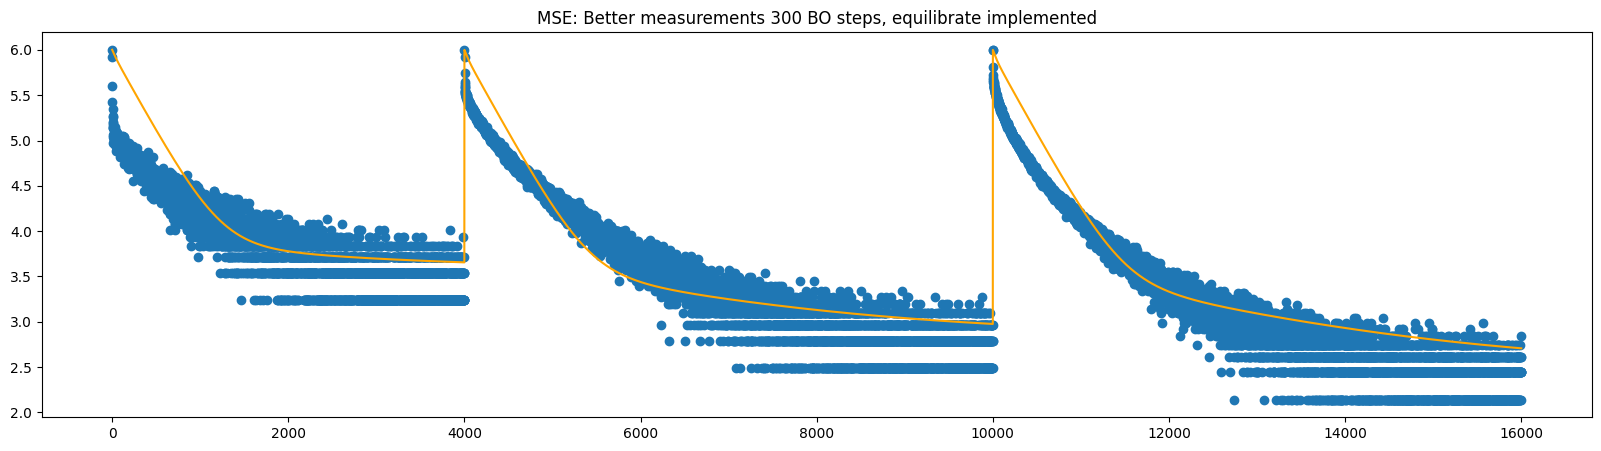

In [89]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, mo_new.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension= True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

In [99]:
mo_new.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.813748640924773e+22, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.7795748543097088e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=2.2421841644887835e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(n

In [121]:
gradient_mo10.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.65797229030013e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=5.294330860039956e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=9.258717133309414e+22, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.487742975940325e-17, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),


In [112]:
gradient_mo8 = deepcopy(mo_new) # get the best parameters

for p, pBO in zip(gradient_mo8.params,mo_new.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent
    p.relRange = 1

    if('ETrap2' in p.name):
        p.lims = [0.7, 1.599]
    
    if('ETrap3' in p.name):
        p.lims = [0.7, 1.599]

    # if('Bulk_tr' in p.name):
    #     p.lims = [1e+19, 1e+26]

    # if(p.name == 'Bn3'):
    #     p.lims = [1e-22, 1e-12]

    # if(p.name == 'Bp1'):
    #     p.lims = [1e-22, 1e-12]

    if(p.name == 'kdirect'):
        p.relRange = 0

    if(p.name == 'N0_gen'):
        p.relRange = 0

    if(p.name == 'alpha'):
        p.relRange = 0

    if(p.name == 'L'):
        p.relRange = 0

    if(p.name == 'N0'):
        p.relRange = 0

    if(p.name == 'Eg'):
        p.relRange = 0
    
    if(p.name == 'Nc'):
        p.relRange = 0
    
    if(p.name == 'Nv'):
        p.relRange = 0

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo8.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(22.945160660717132), np.float64(20.250316260465706), np.float64(20.350671281022763), np.float64(-16.355701141731725), np.float64(-16.0), np.float64(-15.225774766656864), np.float64(-16.36198520060868), np.float64(-17.929785545133214), np.float64(-29.140097553452367), np.float64(1.1248181917665623), np.float64(1.4), np.float64(1.4)] [np.float64(19.0), np.float64(19.0), np.float64(19.0), np.float64(-20.0), np.float64(-16.0), np.float64(-16.0), np.float64(-25.0), np.float64(-30.0), np.float64(-30.0), np.float64(0.3), np.float64(0.7), np.float64(0.7)] [np.float64(25.0), np.float64(25.0), np.float64(25.0), np.float64(-8.0), np.float64(-7.0), np.float64(-7.0), np.float64(-10.0), np.float64(-15.0), np.float64(-15.0), np.float64(1.599), np.float64(1.599), np.float64(1.599)]


MSE = 0.03855188560660392


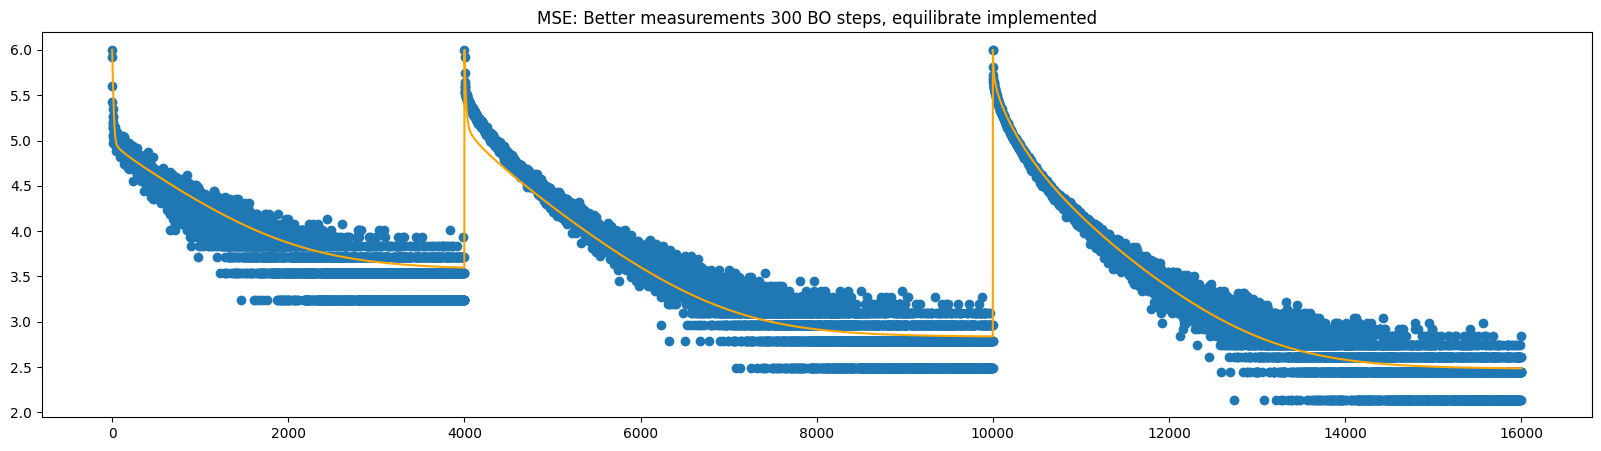

In [113]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, gradient_mo8.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension= True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

MSE = 0.04056202772194704


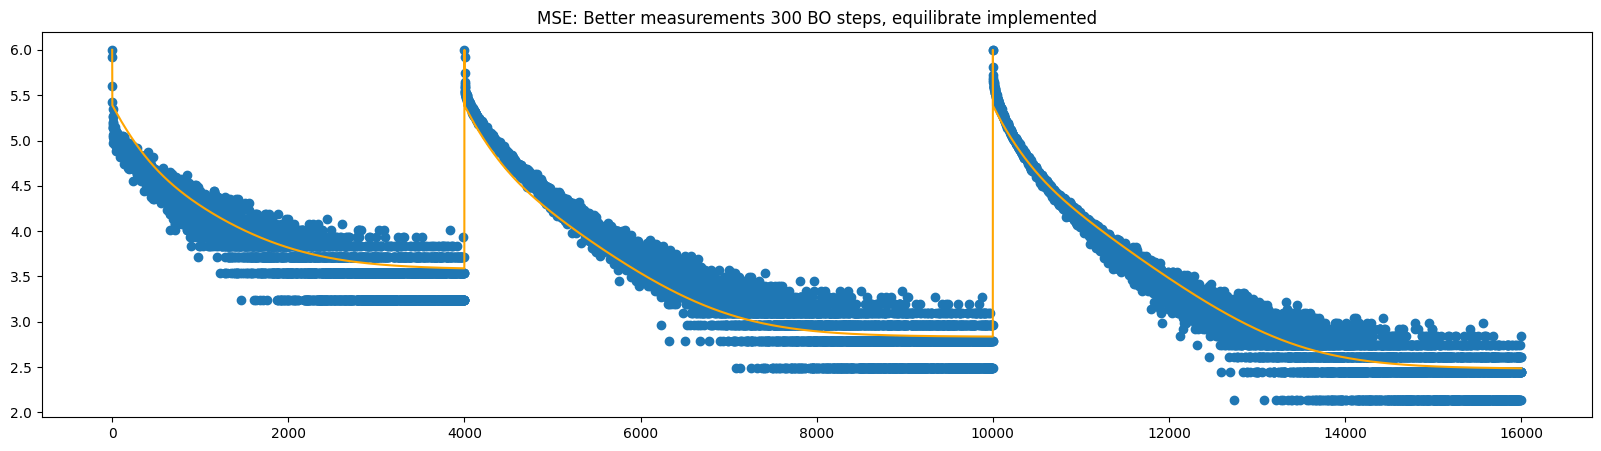

In [32]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, gradient_mo8.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, vectorised = True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

In [115]:
gradient_mo8.params.pop(0)

Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log)

In [116]:
gradient_mo8.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.889534267267845e+22, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.638761377860444e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=7.786292287523071e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=5.823121548091724e-17, relRange=1, lims=[1e-20, 1e-08], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),

In [97]:
gradient_mo15.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1e-17, relRange=1, lims=[1e-18, 1e-16], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=6.125054657728476e+22, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1.8693803507958968e+21, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=2.9195567041454434e+21, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(nam

In [117]:
gradient_mo16 = deepcopy(mo_newAfter) # get the best parameters

for p, pBO in zip(gradient_mo16.params,gradient_mo8.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent
    p.lims = pBO.lims
    p.relRange = 1

    # if('Bulk_tr' in p.name):
    #     p.lims = [1e+19, 1e+26]

    # if(p.name == 'Bn3'):
    #     p.lims = [1e-22, 1e-12]

    # if(p.name == 'Bp1'):
    #     p.lims = [1e-22, 1e-12]

    if(p.name == 'kdirect'):
        p.relRange = 0

    if(p.name == 'N0_gen'):
        p.relRange = 0

    if(p.name == 'alpha'):
        p.relRange = 0

    if(p.name == 'L'):
        p.relRange = 0

    if(p.name == 'N0'):
        p.relRange = 0

    if(p.name == 'Eg'):
        p.relRange = 0
    
    if(p.name == 'Nc'):
        p.relRange = 0
    
    if(p.name == 'Nv'):
        p.relRange = 0

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo16.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(22.948879008388214), np.float64(20.214515719999348), np.float64(20.891330702551397), np.float64(-16.234844144613838), np.float64(-15.172778794007776), np.float64(-12.887847747030467), np.float64(-16.042948736819195), np.float64(-17.067326073642956), np.float64(-28.114076998785002), np.float64(8.476936459651261), np.float64(1.2458801917791018), np.float64(1.3378159296392722)] [np.float64(19.0), np.float64(19.0), np.float64(19.0), np.float64(-20.0), np.float64(-16.0), np.float64(-16.0), np.float64(-25.0), np.float64(-30.0), np.float64(-30.0), np.float64(2.9999999999999996), np.float64(0.7), np.float64(0.7)] [np.float64(25.0), np.float64(25.0), np.float64(25.0), np.float64(-8.0), np.float64(-7.0), np.float64(-7.0), np.float64(-10.0), np.float64(-15.0), np.float64(-15.0), np.float64(15.989999999999998), np.float64(1.599), np.float64(1.599)]


MSE = 0.02880866409120021


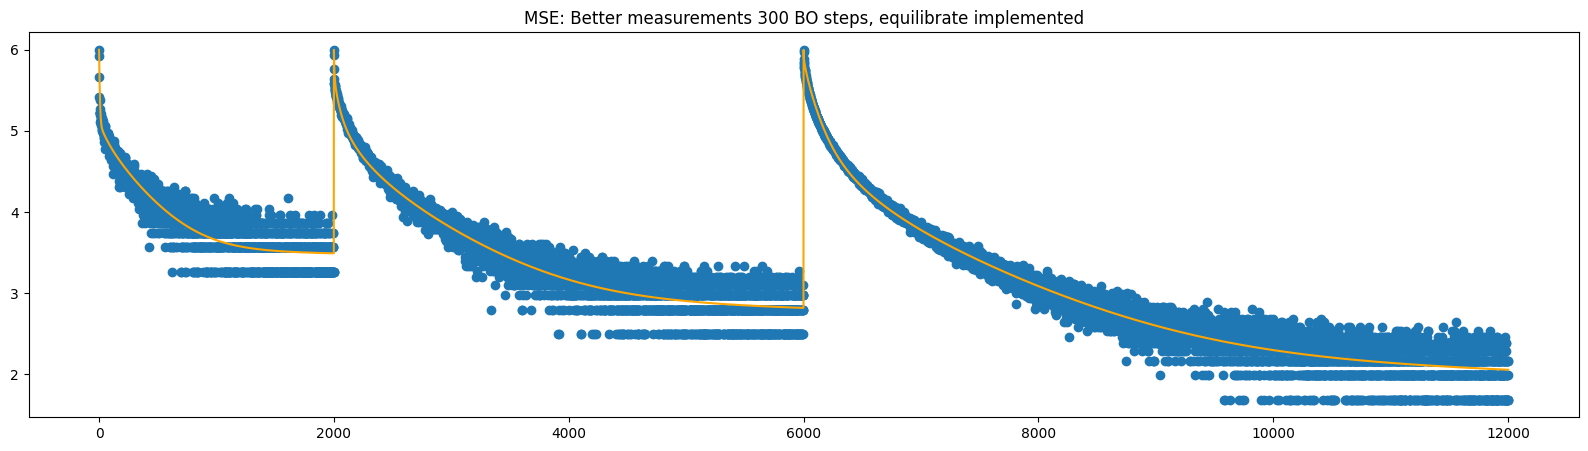

In [118]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data2, gradient_mo16.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")


print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

MSE = 0.03768716790623476


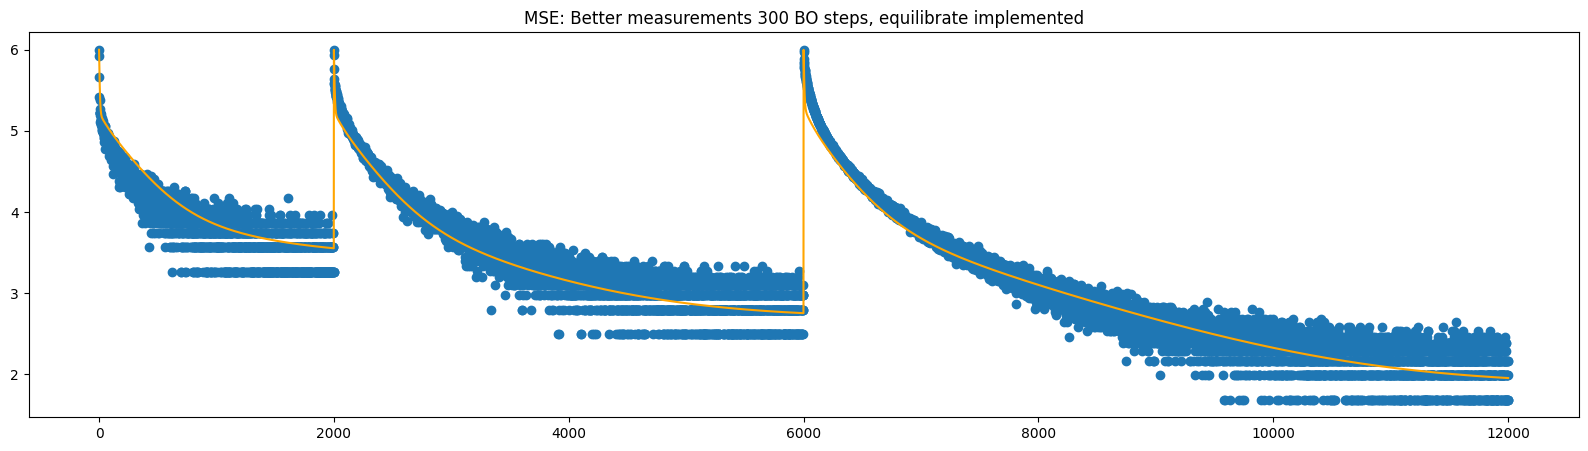

In [106]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data2, gradient_mo15.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")


print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [38]:
gradient_mo8.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.65797229030013e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=5.294330860039956e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=9.258717133309414e+22, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.487742975940325e-17, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),


In [36]:
gradient_mo9.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.627254487726712e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.7036791121259646e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=4.15788505724589e+22, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=4.897897662272969e-17, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),

In [37]:
gradient_mo10.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=3.786932707812985e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=7.285812383963244e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=6.209063329438772e+22, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=6.393911575514671e-17, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),

MSE = 0.040476391506185504


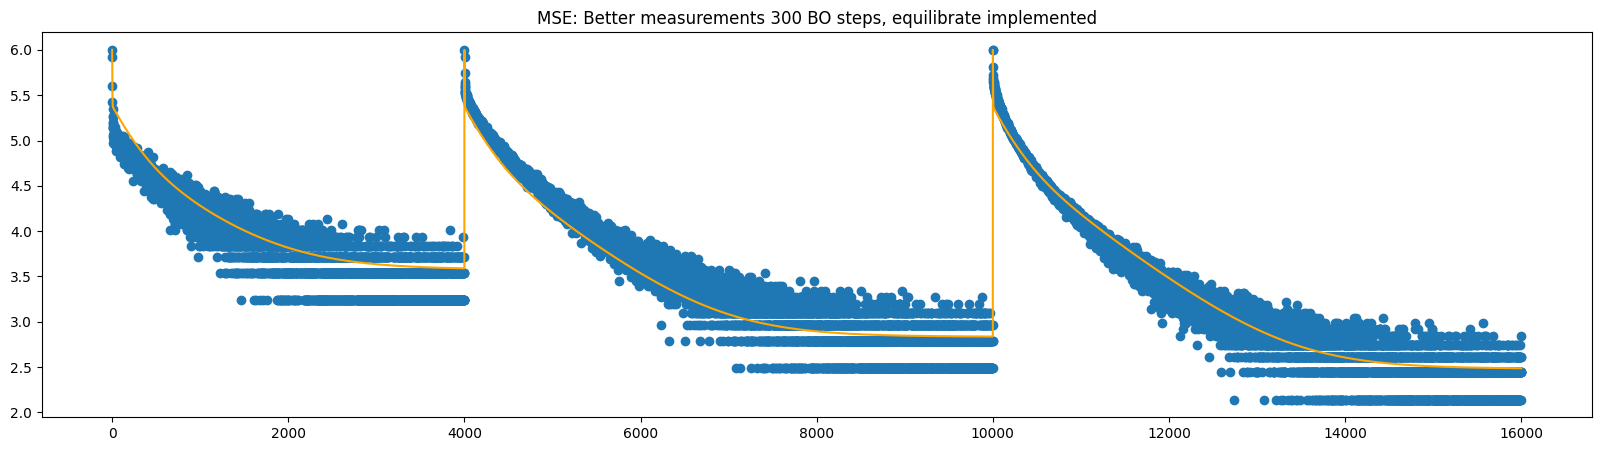

In [34]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data1, gradient_mo9.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, vectorised = True)

plt.scatter(np.arange(len(times_data1)), logdatas1)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas1 - output_after)))))

In [82]:
mo_newAfter.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.3663826821099798e+23, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.1653268031629118e+24, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=4.46367491669733e+23, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=3.115284374282662e-23, relRange=1, lims=[1e-25, 1e-15], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log)

In [93]:
params_before = []
a_MAPI = 31334.55409947516 #From measurements with Manuel

kdirect = Fitparam(name = 'kdirect', val = 1e-17, lims = [1e-18, 1e-16], relRange = 0, range_type = 'log',
                lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'k$_2$',unit='m$^{3}$ s$^{-1}$')
params_before.append(kdirect)

Bulk_tr1 = Fitparam(name = 'Bulk_tr1', val =  true_values['Bulk_tr1'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr1)
Bulk_tr2 = Fitparam(name = 'Bulk_tr2', val =  true_values['Bulk_tr2'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr2)
Bulk_tr3 = Fitparam(name = 'Bulk_tr3', val =  true_values['Bulk_tr3'], lims = [1e19, 1e25], relRange = 1, range_type = 'log',
            lim_type = 'absolute',optim_type = 'log', axis_type='log',display_name= 'Bulk_tr$',unit='m$^{-3}$')
params_before.append(Bulk_tr3)

Bn1 = Fitparam(name = 'Bn1', val = true_values['Bn1'], lims = [1e-25, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn1)
Bn2 = Fitparam(name = 'Bn2', val = true_values['Bn2'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn2)
Bn3 = Fitparam(name = 'Bn3', val = 1e-12, lims = [1e-17, 1e-7], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_n$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bn3)

Bp1 = Fitparam(name = 'Bp1', val = true_values['Bp1'], lims = [1e-25, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp1)
Bp2 = Fitparam(name = 'Bp2', val = true_values['Bp2'], lims = [1e-20, 1e-10], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp2)
Bp3 = Fitparam(name = 'Bp3', val = 1e-20, lims = [1e-25, 1e-15], relRange = 1, range_type = 'log', 
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='B$_p$', unit='m$^{3}$ s$^{-1}$')
params_before.append(Bp3)

ETrap1 = Fitparam(name = 'ETrap1', val = true_values['ETrap1'], lims = [0.7, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single1}$', unit='eV')
params_before.append(ETrap1)
ETrap2 = Fitparam(name = 'ETrap2', val = true_values['ETrap2'], lims = [trPLs_after.BG-0.4, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single2}$', unit='eV')
params_before.append(ETrap2)
ETrap3 = Fitparam(name = 'ETrap3', val = 1.4, lims =[0.7, trPLs_after.BG-0.001], relRange = 1, range_type = 'linear', 
            lim_type = 'absolute', optim_type = 'linear', axis_type = 'linear', display_name='E${trap-single3}$', unit='eV')
params_before.append(ETrap3)

N0_gen = Fitparam(name='N0_gen', val=N0s_after[0], lims = [1e13, 1e14], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(N0_gen)

alpha = Fitparam(name='alpha', val=1e2*a_MAPI, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(alpha)

L = Fitparam(name='L', val=450e-9, lims = [1e12, 1e13], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(L)

N0 = Fitparam(name='N0', val=N0_gen.val/L.val, lims = [1e20, 1e21], relRange = 0, range_type = 'log',
            lim_type = 'absolute', optim_type = 'log', axis_type = 'log', display_name='N$_0$', unit='m$^{3}$')
params_before.append(N0)

BG = Fitparam(name='Eg', val=trPLs_after.BG, relRange = 0, display_name='E$_g$', unit='eV$')
params_before.append(BG)

Nc = Fitparam(name='Nc', val=1e6*trPLs_after.Nc, relRange = 0, display_name='N$_c$', unit='m$^{-3}$')
params_before.append(Nc)

Nv = Fitparam(name='Nv', val=1e6*trPLs_after.Nv, relRange = 0, display_name='N$_v$', unit='m$^{-3}$')
params_before.append(Nv)

In [67]:
mo_newAfter.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.8429428602862882e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.2504252371399677e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1e+25, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.9754215619295016e-14, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(na

In [94]:
#Fit 1: Before
if 'mo_before' in locals():
    del mo_before

for i in range(1):
    print("-------------------------------------------------------------------Starting Fit: "+str(i)+"--------------------------------------------------------")
    X_dimension = ['t']
    y_dimension = 'PL [a.u.]'

    trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

    if 'target' in locals():
        del target

    if 'mo_newAfter' in locals():
        del mo_newAfter

    target = {'model':partial(trPL_agent.TRPL_function, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True), 'target_name':'trPL', 
              'data':{'X':times_data2, 'y':logdatas2, 'X_dimensions':X_dimension, 'X_units':'s', 'y_dimension':y_dimension, 'y_unit':''}, 'weight': 1, 'target_weight':1}

    mo_newAfter = MooBOtorch(targets = [target], params = params_before, res_dir=res_dir, parallel=False, verbose=True)
    obj_type="MSE" #MLE_trPL_MS"#'MSE'#'hausdorff'
    loss= 'linear' #'soft_l1' #It takes the sqrt(MSE)
    threshold=0.5#50

    kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':true_values,'show_points':True,'savefig':False,'full_grid':True,'randomize':True}

    # ax_client = mo_newAfter.BoTorchOpti(n_jobs = [4,4], n_step_points = [150, 300], models = ['Sobol','GPEI'], obj_type = obj_type, loss = loss, threshold = threshold,use_CUDA=False,is_MOO = False, verbose = True, show_posterior = False, kwargs_posterior = kwargs_posterior)
    
    # import pickle
    # with open('./250521-results_BOs-MAPIAfter-N0Fixed-kradFixed-TwoDeepOneShalowTrap-powersratios-150300times-'+str(4)+'.pickle', 'wb') as handle:
    #     pickle.dump(mo_newAfter, handle, protocol=pickle.HIGHEST_PROTOCOL)

-------------------------------------------------------------------Starting Fit: 0--------------------------------------------------------


In [86]:
len(times_data2)

12001

MSE = 0.10914175503686231


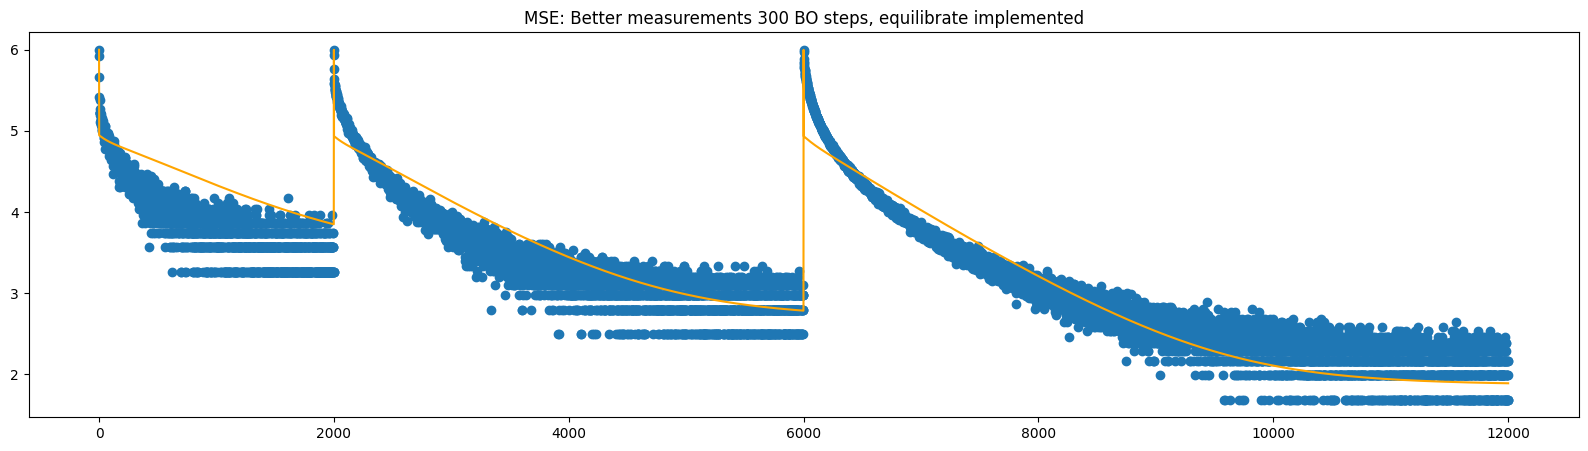

In [84]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data2, mo_newAfter.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")


print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [65]:
mo_newAfter.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=2.8429428602862882e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.2504252371399677e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=1e+25, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.9754215619295016e-14, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(na

In [64]:
gradient_mo10.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1.3058551754597311e+21, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.1001380674638422e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=8.515147773659986e+24, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=1.3673741977293371e-14, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=lo

In [80]:
gradient_mo10 = deepcopy(mo_newAfter) # get the best parameters

for p, pBO in zip(gradient_mo10.params,mo_newAfter.params):
    p.val = pBO.val
    p.startVal = pBO.val # reset the start values to the best ones before starting the gradient descent
    #p.relRange = 1

    # if(p.name == 'Bulk_tr1'):
    #     p.lims = [1e21, 1e26]

    # if(p.name == 'Bulk_tr2'):
    #     p.lims = [1e21, 1e26]

    #if(p.name == 'ETrap3'):
     #   p.lims = [0.2,1.552]

    if(p.name == 'kdirect'):
        p.relRange = 0

    if(p.name == 'N0_gen'):
        p.relRange = 0

    if(p.name == 'alpha'):
        p.relRange = 0

    if(p.name == 'L'):
        p.relRange = 0

    if(p.name == 'N0'):
        p.relRange = 0

    if(p.name == 'Eg'):
        p.relRange = 0
    
    if(p.name == 'Nc'):
        p.relRange = 0
    
    if(p.name == 'Nv'):
        p.relRange = 0

    # if(p.name == 'Bn3'):
    #     p.lims = [1e-22, 1e-12]

    # if(p.name == 'Bp1'):
    #     p.lims = [1e-22, 1e-12]

kwargs_curve =  {'ftol':1e-11, 'xtol':1e-11, 'gtol': 1e-11, 'diff_step':0.00001,'loss':'linear','maxfev':100000}

print('Start curve fit')
try:
    rc = gradient_mo10.optimize_curvefit(kwargs=kwargs_curve) # fit the best parameters to the data
except Exception as e:
    print(e)
    print('Curve fit did not find a better solution')

Start curve fit
[np.float64(23.374084978368675), np.float64(24.06644773558287), np.float64(23.64969255801164), np.float64(-22.506502303244066), np.float64(-16.96988886067841), np.float64(-7.597027501282673), np.float64(-21.084730264805536), np.float64(-13.955420341994648), np.float64(-19.000338737188862), np.float64(1.467859868349205), np.float64(1.4243080874176726), np.float64(1.500014281704983)] [np.float64(19.0), np.float64(19.0), np.float64(19.0), np.float64(-25.0), np.float64(-20.0), np.float64(-17.0), np.float64(-25.0), np.float64(-20.0), np.float64(-25.0), np.float64(0.7), np.float64(1.2000000000000002), np.float64(0.7)] [np.float64(25.0), np.float64(25.0), np.float64(25.0), np.float64(-15.0), np.float64(-10.0), np.float64(-7.0), np.float64(-15.0), np.float64(-10.0), np.float64(-15.0), np.float64(1.5990000000000002), np.float64(1.5990000000000002), np.float64(1.5990000000000002)]


MSE = 0.04372725139842604


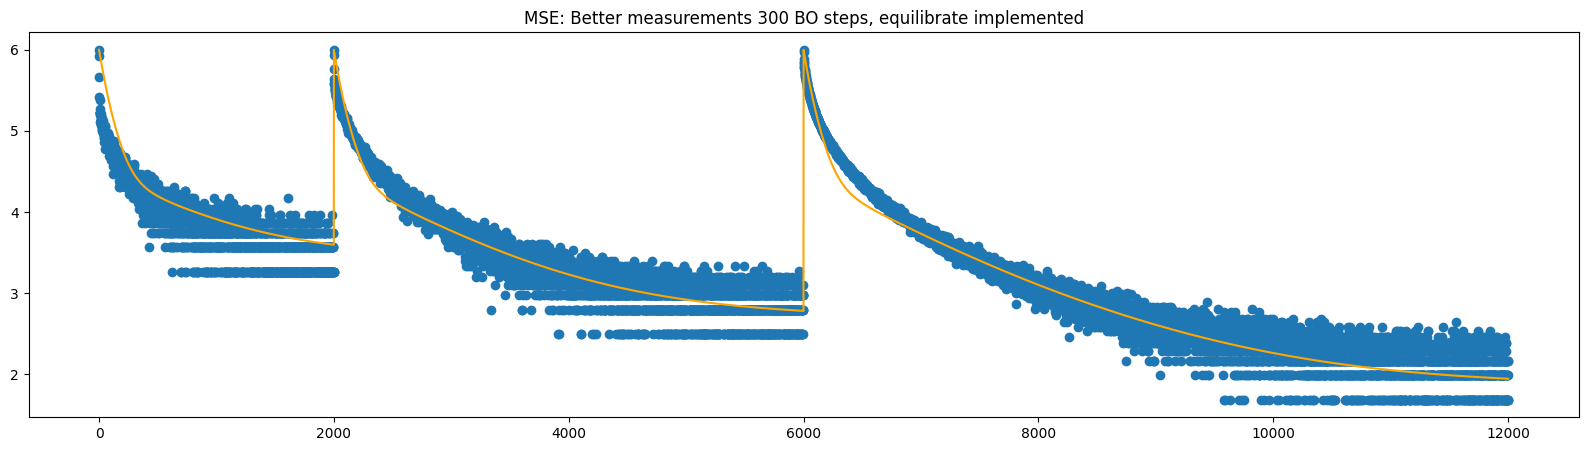

In [81]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()
output_after = trPL_agent.TRPL_function(times_data2, gradient_mo10.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)

plt.scatter(np.arange(len(times_data2)), logdatas2)
plt.plot(np.arange(len(output_after)), output_after, color = 'orange')
plt.yscale("linear")
plt.title("MSE: Better measurements 300 BO steps, equilibrate implemented")

print("MSE = "+str(np.mean(np.square((logdatas2 - output_after)))))

In [119]:
import pickle
with open('./250526-GradientBefore-FromBO250526.pickle', 'wb') as handle:
    pickle.dump(gradient_mo8, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./250526-GradientBefore-FromBO250515.pickle', 'wb') as handle:
    pickle.dump(gradient_mo8, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
with open('./250526-GradientAfter-FromBefore.pickle', 'wb') as handle:
    pickle.dump(gradient_mo16, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analyse Best Fits

In [17]:
# Fit three traps:
import pickle
with open(r'C:\Users\local_admin\Documents\Simulations-Chapter1\LPtrPLHUBLA\250515-GradientBefore-FromAfter.pickle', 'rb') as f:
    bestFit_before = pickle.load(f)

# with open(r'C:\Users\local_admin\Documents\Simulations-Chapter1\LPtrPLFAPI\Fits-FAPI-Statistics-NEWNEW\Before-TwoTraps\250206-results_BOs-0nsdelay-FAPIBefore-OneDeepOneShallow-powersratios-150250times.pickle', 'rb') as f:
    # bestFit_before = pickle.load(f)
# 
# with open(r'/250429-Gradient-optimisedAfter.pickle', 'rb') as f:
#     bestFit_after = pickle.load(f)

with open(r'C:\Users\local_admin\Documents\Simulations-Chapter1\LPtrPLHUBLA\250515-GradientAfter-FromBO250515.pickle', 'rb') as f:
    bestFit_after = pickle.load(f)


In [121]:
bestFit_before = deepcopy(gradient_mo8)
bestFit_after = deepcopy(gradient_mo16)

In [122]:
bestFit_before.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=8.889534267267845e+22, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=1.638761377860444e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=7.786292287523071e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=5.823121548091724e-17, relRange=1, lims=[1e-20, 1e-08], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),

In [123]:
bestFit_after.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=1.3001379337908461e+23, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=2.317909945188326e+21, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=3.125625920830389e+20, relRange=1, lims=[1e+19, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=6.914315647831387e-17, relRange=1, lims=[1e-20, 1e-08], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log)

In [ ]:
bestFit_before.params[1].val - 4.0

np.float64(2.627254487726712e+23)

In [125]:
param_selec1 = [1,2,3,4,5,6,7,8,9]
param_selec2 = [1,2,3,4,5,6,7,8,9]
n = 64
MSEs_before = np.zeros((len(param_selec1), n))
MSEs_after = np.zeros((len(param_selec2), n))

Ps_before = np.zeros((len(param_selec1),n))
Ps_after = np.zeros((len(param_selec2),n))

trPL_agent = Custom_rate_eqs_Agent_simu_powerDep_anyTraps_diffusion()

for i, s in enumerate(param_selec2):
    # ps_before_BO = np.logspace(np.log10(gradient_mo8.params[s].lims[0]),np.log10(gradient_mo8.params[s].lims[1]), num=n, endpoint=False)
    # print(gradient_mo8.params[s].name)
    # params_before_BO = deepcopy(gradient_mo8)
    # mses_before_BO = np.zeros(n)
    ps_before = np.logspace(np.log10(bestFit_before.params[s].val) - 4.0, np.log10(bestFit_before.params[s].val) + 4.0, num=n, endpoint=False)
    print(bestFit_before.params[s].name)
    params_before = deepcopy(bestFit_before)
    mses_before = np.zeros(n)

    params_after = deepcopy(bestFit_after)
    ps_after = np.logspace(np.log10(bestFit_after.params[s].val) - 4.0, np.log10(bestFit_after.params[s].val) + 4.0, num=n, endpoint=False)
    #ps_after = bestFit_after.params[s].val*np.logspace(-2,2, num=n, endpoint=False)
    print(bestFit_after.params[s].name)
    mses_after = np.zeros(n)

    for j, (pb, pa) in enumerate(zip(ps_before, ps_after)):
        params_before.params[s].val = pb
        output_b = trPL_agent.TRPL_function(times_data1, params_before.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)
        mse_b = np.mean(np.square((logdatas1 - output_b)))
        mses_before[j] = mse_b
    
        params_after.params[s].val = pa
        output_a = trPL_agent.TRPL_function(times_data2, params_after.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)
        mse_a = np.mean(np.square((logdatas2 - output_a)))
        mses_after[j] = mse_a
    
     
    Ps_before[i] = ps_before
    MSEs_before[i] = mses_before

    Ps_after[i] = ps_after
    MSEs_after[i] = mses_after

Bulk_tr1
Bulk_tr1
Bulk_tr2
Bulk_tr2
Bulk_tr3
Bulk_tr3
Bn1
Bn1
Bn2
Bn2
Bn3
Bn3
Bp1
Bp1
Bp2
Bp2
Bp3
Bp3


In [75]:
params_after.params

[Fitparam(name=kdirect, val=1e-17, relRange=0, lims=[1e-18, 1e-16], std=0, d=, display_name=k$_2$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr1, val=3.786932707812985e+23, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr2, val=7.285812383963244e+20, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bulk_tr3, val=6.209063329438772e+22, relRange=1, lims=[1e+18, 1e+25], std=1.0, d=, display_name=Bulk_tr$, unit=m$^{-3}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),
 Fitparam(name=Bn1, val=6.393911575514671e-17, relRange=1, lims=[1e-20, 1e-10], std=1.0, d=, display_name=B$_n$, unit=m$^{3}$ s$^{-1}$, range_type=log, lim_type=absolute, optim_type=log, axis_type=log),

In [127]:
param_selec1 = [10,11,12]
param_selec2 = [10,11,12]

n = 64
MSEs_b_trapDepth = np.zeros((len(param_selec1), n))
MSEs_a_trapDepth = np.zeros((len(param_selec2), n))

Ps_b_trapDepth = np.zeros((len(param_selec1),n))
Ps_a_trapDepth = np.zeros((len(param_selec2),n))

for i, s in enumerate(param_selec2):
    params_before = deepcopy(bestFit_before)
    print(params_before.params[s].name)
    #ps_before = np.linspace(params_before.params[s-3].lims[0], params_before.params[s-3].lims[1], num=n, endpoint=True)
    ps_before = np.linspace(max(params_before.params[s].val-0.4, 0.0), min(params_before.params[s].val+0.4, params_before.params[17].val-0.001), num=n, endpoint=True)

    mses_before = np.zeros(n)

    params_after = deepcopy(bestFit_after)
    print(params_after.params[s].name)
    #ps_after = np.linspace(params_after.params[s].lims[0], params_after.params[s].lims[1], num=n, endpoint=True)
    ps_after = np.linspace(max(params_after.params[s].val-0.4, 0.0), min(params_after.params[s].val+0.4, params_before.params[17].val-0.001), num=n, endpoint=True)
    mses_after = np.zeros(n)

    for j, (pb, pa) in enumerate(zip(ps_before, ps_after)):
        
        params_before.params[s].val = pb
        output_b = trPL_agent.TRPL_function(times_data1, params_before.params, take_Log = True, Gs = np.array(trPLs.powers)/trPLs.powers[0], constant_floor_normalised_raw=noises1, reprates = trPLs.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)
        mse_b = np.mean(np.square((logdatas1 - output_b)))
        mses_before[j] = mse_b

        params_after.params[s].val = pa
        output_a = trPL_agent.TRPL_function(times_data2, params_after.params, take_Log = True, Gs = np.array(trPLs_after.powers)/trPLs_after.powers[0], constant_floor_normalised_raw=noises2, reprates = trPLs_after.reprates_Hz, N_x = 20, equilibrate=True, nondimension = True)
        mse_a = np.mean(np.square((logdatas2 - output_a)))
        mses_after[j] = mse_a
    
    Ps_b_trapDepth[i] = ps_before
    MSEs_b_trapDepth[i] = mses_before
    Ps_a_trapDepth[i] = ps_after
    MSEs_a_trapDepth[i] = mses_after

ETrap1
ETrap1
ETrap2
ETrap2
ETrap3
ETrap3


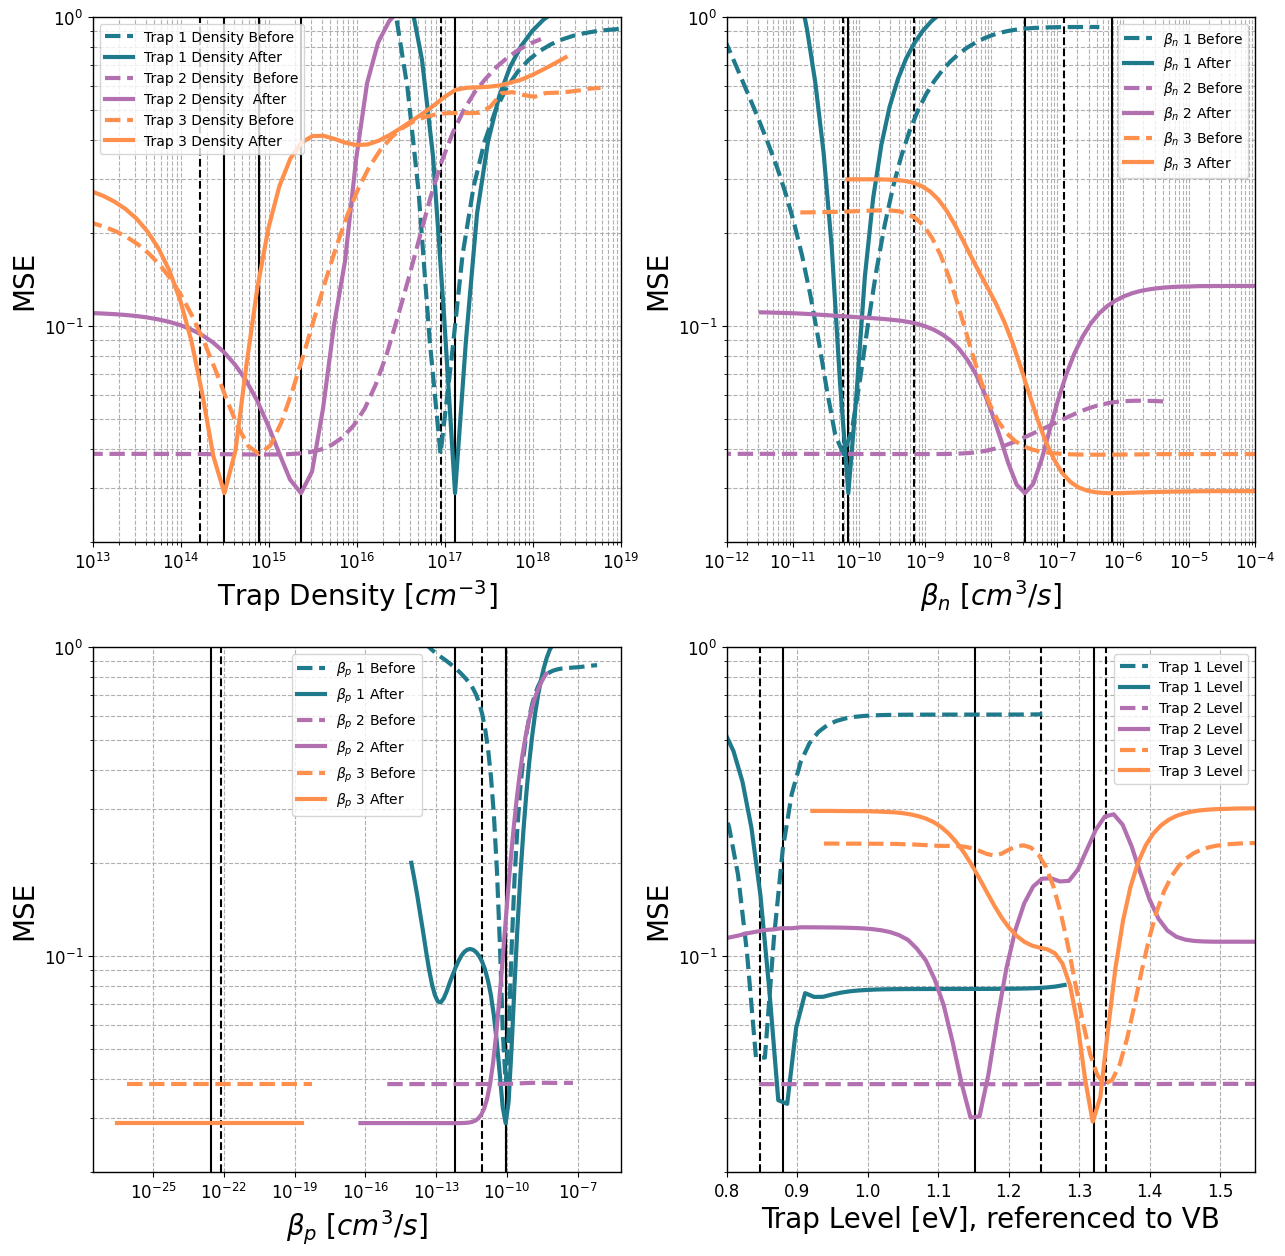

In [131]:
fig, ax = plt.subplots(2,2, figsize = (15,15))

colors = ['#1f7a8cff', '#b370b0ff', "#ff8f4cff"]
colors1 = ['#1f7a8cff', '#b370b0ff', "#ff8f4cff"]

colors_traps = ["black", "grey",'#1f7a8cff', '#b370b0ff', "#ff8f4cff"]

names_new2 = [ 'Trap 1 Density', 'Trap 2 Density ', 'Trap 3 Density', r"$\beta_n$ 1",r"$\beta_n$ 2", r"$\beta_n$ 3", r"$\beta_p$ 1", r"$\beta_p$ 2", r"$\beta_p$ 3"]
names_new1 = names_new2
names_new_traps = ['Trap 1 Level', 'Trap 2 Level',  'Trap 3 Level']
lw = 3
i=0
ax[0,i].axvline(1e-6*bestFit_before.params[i+1].val, color = 'black', linestyle = '--')
ax[0,i].axvline(1e-6*bestFit_after.params[i+1].val, color = 'black')
ax[0,i].axvline(1e-6*bestFit_before.params[i+2].val, color = 'black', linestyle = '--')
ax[0,i].axvline(1e-6*bestFit_after.params[i+2].val, color = 'black')
ax[0,i].axvline(1e-6*bestFit_before.params[i+3].val, color = 'black')
ax[0,i].axvline(1e-6*bestFit_after.params[i+3].val, color = 'black')
i=1
j=4
ax[0,i].axvline(1e6*bestFit_before.params[j].val, color = 'black', linestyle = '--')
ax[0,i].axvline(1e6*bestFit_after.params[j].val, color = 'black')
ax[0,i].axvline(1e6*bestFit_before.params[j+1].val, color = 'black', linestyle = '--')
ax[0,i].axvline(1e6*bestFit_after.params[j+1].val, color = 'black')
ax[0,i].axvline(1e6*bestFit_before.params[j+2].val, color = 'black', linestyle = '--')
ax[0,i].axvline(1e6*bestFit_after.params[j+2].val, color = 'black')
i=0
j=7
ax[1,i].axvline(1e6*bestFit_before.params[j].val, color = 'black', linestyle = '--')
ax[1,i].axvline(1e6*bestFit_after.params[j].val, color = 'black')
ax[1,i].axvline(1e6*bestFit_before.params[j+1].val, color = 'black', linestyle = '--')
ax[1,i].axvline(1e6*bestFit_after.params[j+1].val, color = 'black')
ax[1,i].axvline(1e6*bestFit_before.params[j+2].val, color = 'black', linestyle = '--')
ax[1,i].axvline(1e6*bestFit_after.params[j+2].val, color = 'black')
i=1
j=10
ax[1,i].axvline(bestFit_before.params[j].val, color = 'black', linestyle = '--')
ax[1,i].axvline(bestFit_after.params[j].val, color = 'black')
ax[1,i].axvline(bestFit_before.params[j+1].val, color = 'black', linestyle = '--')
ax[1,i].axvline(bestFit_after.params[j+1].val, color = 'black')
ax[1,i].axvline(bestFit_before.params[j+2].val, color = 'black', linestyle = '--')
ax[1,i].axvline(bestFit_after.params[j+2].val, color = 'black')

fontsize = 20
ax[0,0].set_xlabel(r'Trap Density $[cm^{-3}]$', size=fontsize)
ax[0,1].set_xlabel('Electron Capture Crossection [cm^3/s]', size=fontsize)
ax[0,1].set_xlabel(r'$\beta_n$ $[cm^3/s]$', size=fontsize)
ax[1,0].set_xlabel('Hole Capture Crossection [cm^3/s]', size=fontsize)
ax[1,0].set_xlabel(r'$\beta_p$ $[cm^3/s]$', size=fontsize)
ax[1,1].set_xlabel('Trap Level [eV], referenced to VB', size=fontsize)

for i, (ps_b, mse_b, ps_a, mse_a) in enumerate(zip(Ps_before, MSEs_before, Ps_after, MSEs_after)):
    if (i<3): #density
        ax[0,0].loglog(1e-6*ps_b, mse_b, label = names_new1[i]+" Before", color = colors1[i%3], linestyle = '--', linewidth = lw)
        ax[0,0].loglog(1e-6*ps_a, mse_a, label = names_new2[i]+" After", color = colors1[i%3], linewidth = lw)
    elif(i<6): #Bn
        ax[0,1].loglog(1e6*ps_b, mse_b, label = names_new1[i]+" Before", color = colors1[i%3], linestyle = '--', linewidth = lw)
        ax[0,1].loglog(1e6*ps_a, mse_a, label = names_new2[i]+" After", color = colors1[i%3], linewidth = lw)
    elif(i<9): #Bp
        ax[1,0].loglog(1e6*ps_b, mse_b, label = names_new1[i]+" Before", color = colors1[i%3], linestyle = '--', linewidth = lw)
        ax[1,0].loglog(1e6*ps_a, mse_a, label = names_new2[i]+" After", color = colors1[i%3], linewidth = lw)

for i, (ps_b, mse_b, ps_a, mse_a) in enumerate(zip(Ps_b_trapDepth, MSEs_b_trapDepth, Ps_a_trapDepth, MSEs_a_trapDepth)):
    ax[1,1].semilogy(ps_b, mse_b, color = colors1[i%3], label = names_new_traps[i], linestyle = '--', linewidth = lw)
    ax[1,1].semilogy(ps_a, mse_a, color = colors1[i%3] , label = names_new_traps[i], linewidth = lw)

ax[0,0].set_xlim(1e13, 1e19)
ax[0,1].set_xlim(1e-12, 1e-4)
ax[1,1].set_xlim(0.8,1.55)

for b in ax:
    for a in b:
        axisTicks_fontsize = 12
        a.set_ylim(2e-2,1)
        a.tick_params(axis='x', labelsize=axisTicks_fontsize)
        a.tick_params(axis='y', labelsize=axisTicks_fontsize)
        a.legend()
        a.set_ylabel('MSE', size = fontsize)

        a.yaxis.grid(visible = True, which = 'both', linestyle = '--')
        a.xaxis.grid(visible = True, which = 'both', linestyle = '--')

        w_frame = 1.
        a.spines["bottom"].set_linewidth(w_frame)
        a.spines["top"].set_linewidth(w_frame)
        a.spines["left"].set_linewidth(w_frame)
        a.spines["right"].set_linewidth(w_frame)

fig.savefig(r'G:\LastVersion\Graphs\MSEs_MAPI.svg', bbox_inches = 'tight')